In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import operator

from utils import *

## Goose 1st & 2nd

### LR, 62CH, 10S

In [2]:
CH = 'all'
time_window = 10
device = torch.device('cuda')

val_dates = ['180409', '180412', '180414']
test_dates = ['180411', '180413']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_all'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['180409', '180412', '180414'], test dates: ['180411', '180413']
val instances: 6620, val imbalance: 0.8261329531669617
test instances: 6134, test imbalance: 0.7402999401092529
train instances: 44040, train imbalance: 0.5


#### Without regularization

In [4]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.6890923976898193
Val loss for epoch 0: 0.5623505115509033


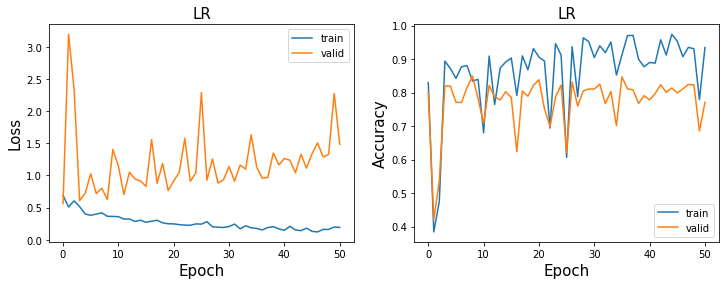

In [5]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.5623505115509033, val accuracy:0.8, val percentage postive:0.8261329531669617


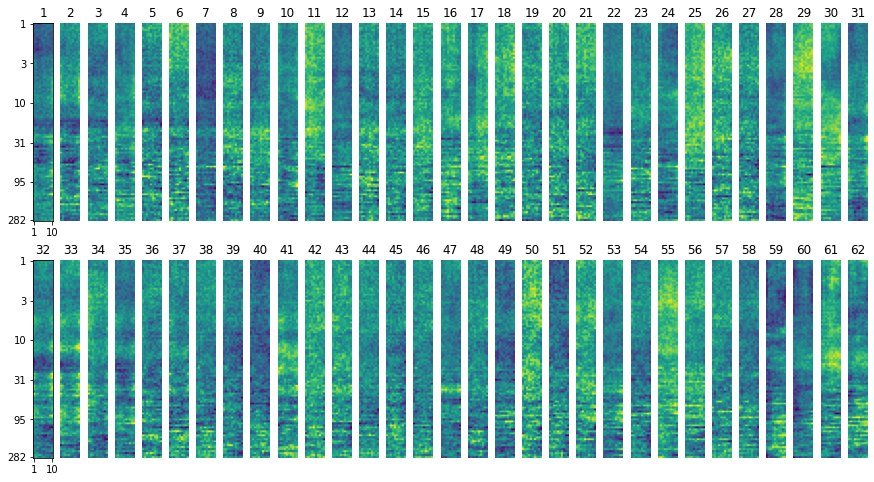

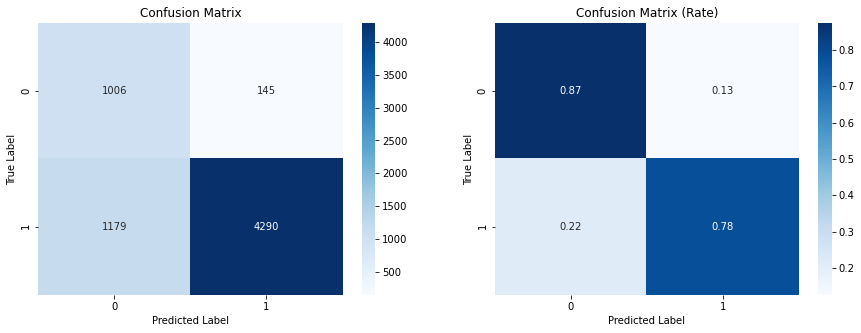

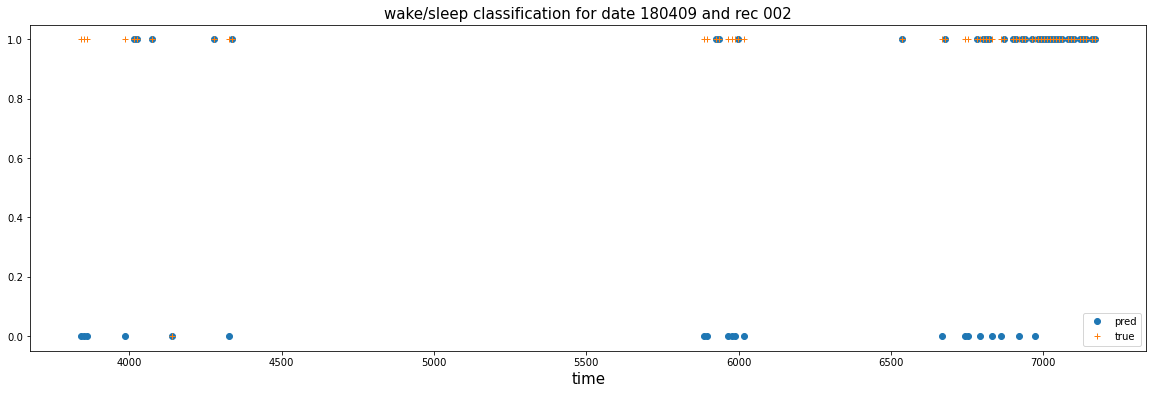

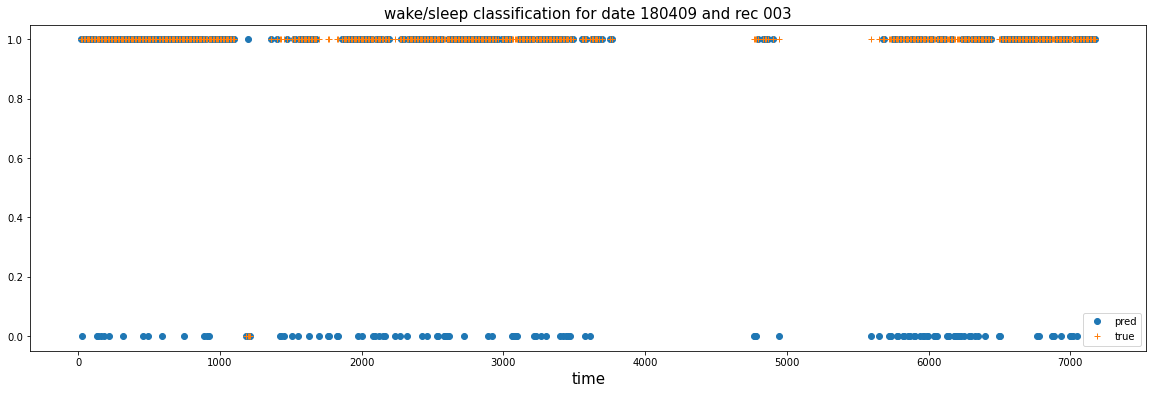

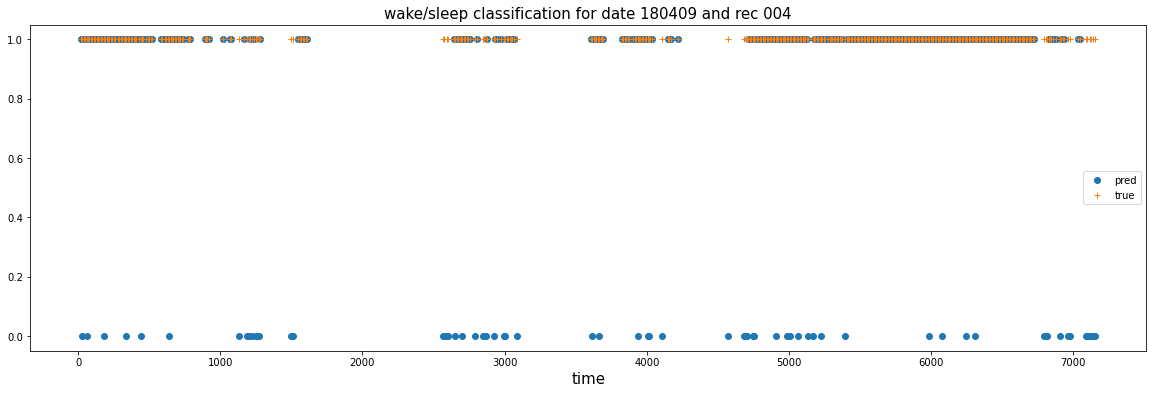

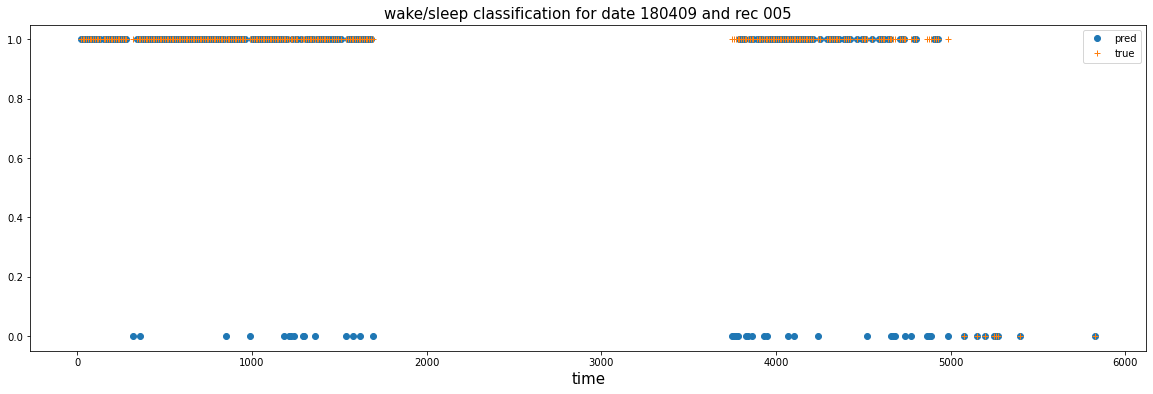

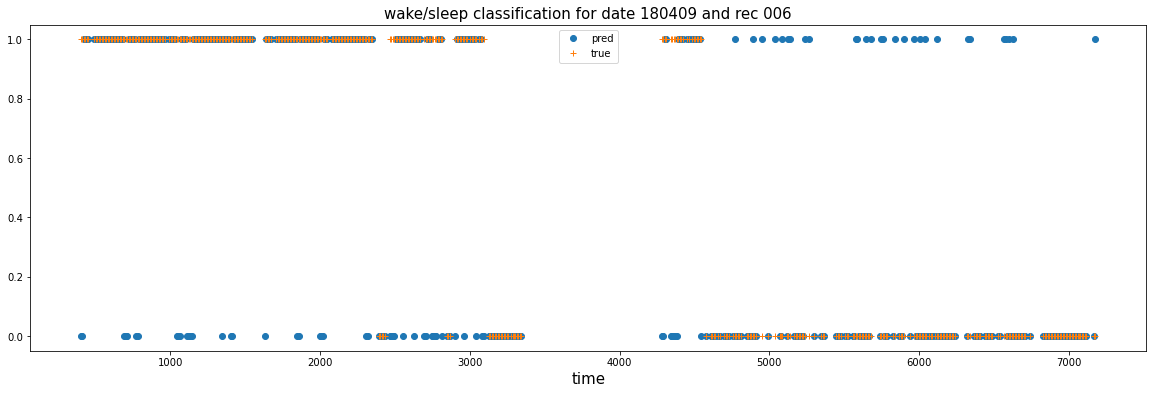

In [6]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.17145930230617523, train accuracy:0.9346503178928247, train percentage postive:0.5


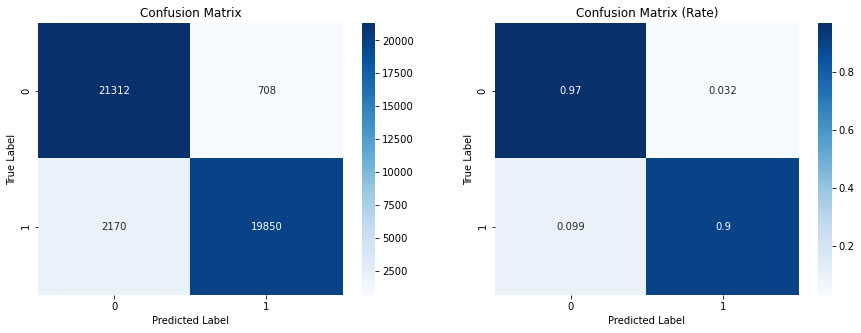

In [7]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.6868433356285095
Val loss for epoch 0: 0.9114193916320801
1
Train loss for epoch 1: 0.5239534974098206
Val loss for epoch 1: 0.5647541284561157


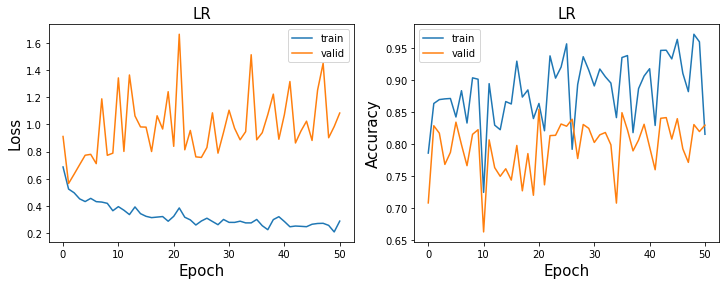

0
Train loss for epoch 0: 0.9240652918815613
Val loss for epoch 0: 0.6422609686851501
5
Train loss for epoch 5: 0.7441840767860413
Val loss for epoch 5: 0.5444942116737366
7
Train loss for epoch 7: 0.6579982042312622
Val loss for epoch 7: 0.4914267957210541
13
Train loss for epoch 13: 0.7227353453636169
Val loss for epoch 13: 0.48931941390037537
28
Train loss for epoch 28: 0.6703439354896545
Val loss for epoch 28: 0.4180864989757538


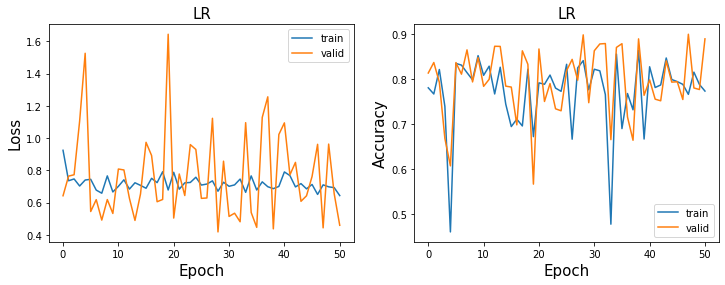

0
Train loss for epoch 0: 1.0119645595550537
Val loss for epoch 0: 0.7433603405952454
6
Train loss for epoch 6: 0.7723804116249084
Val loss for epoch 6: 0.47007834911346436
14
Train loss for epoch 14: 0.8061741590499878
Val loss for epoch 14: 0.4490232765674591
39
Train loss for epoch 39: 0.7454985976219177
Val loss for epoch 39: 0.4451674222946167
46
Train loss for epoch 46: 0.7454662322998047
Val loss for epoch 46: 0.42404672503471375


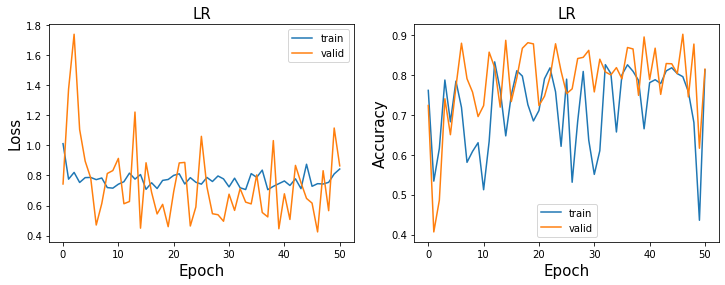

In [9]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.4180864989757538, val accuracy:0.8977341389728096, val percentage postive:0.8261329531669617


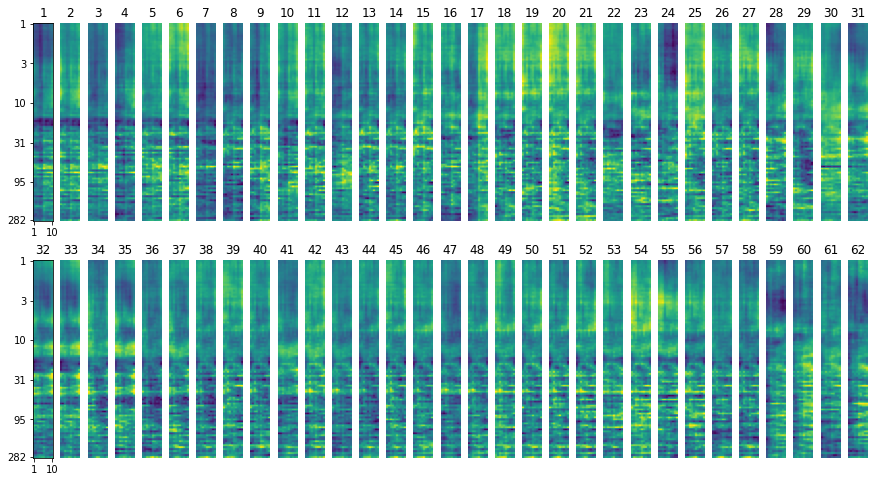

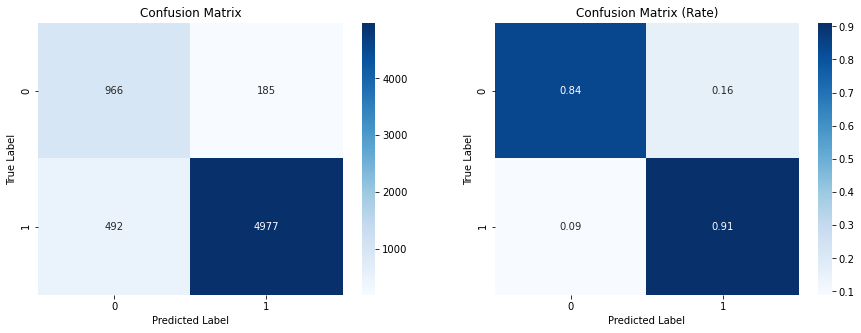

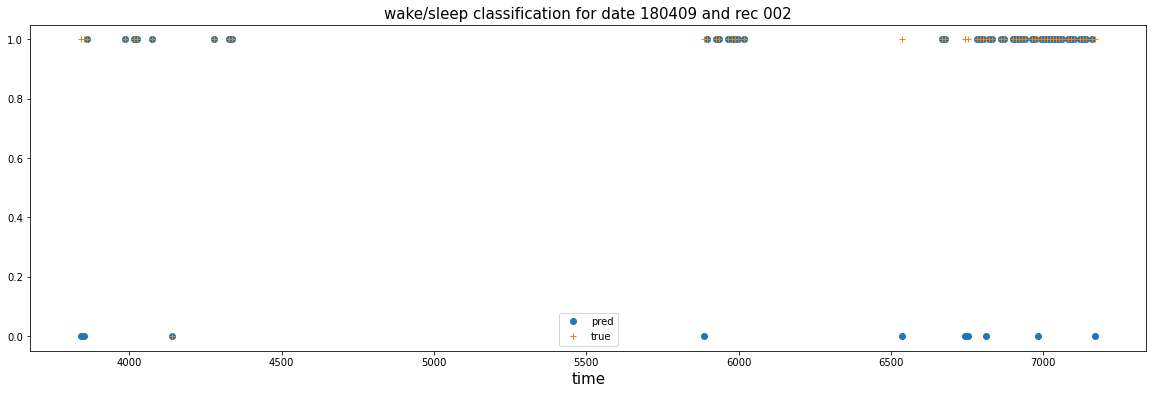

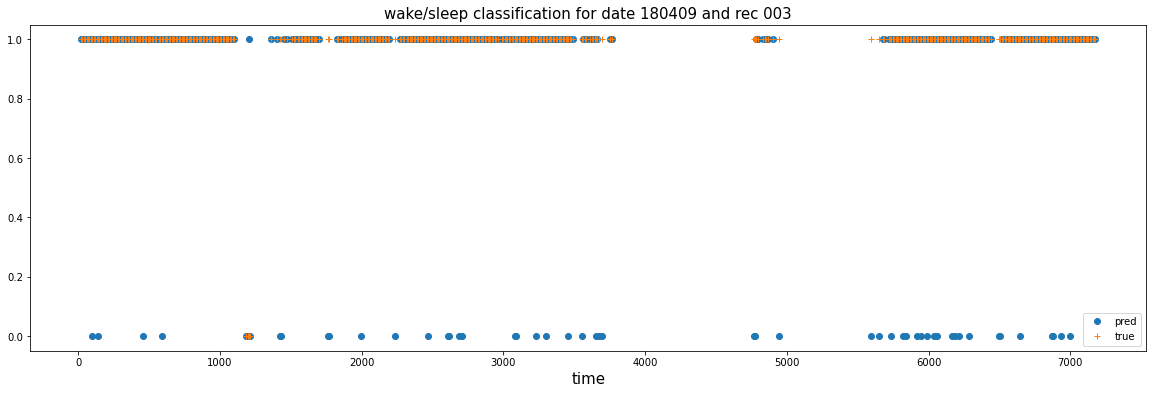

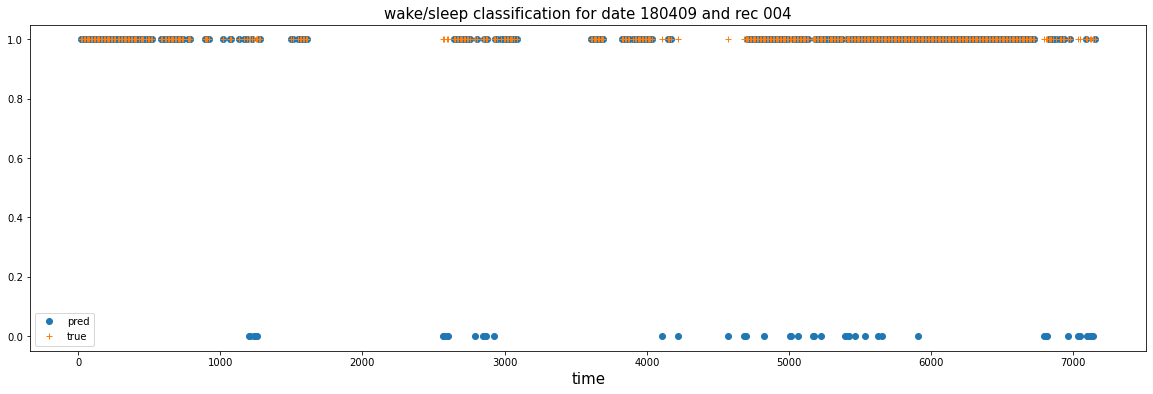

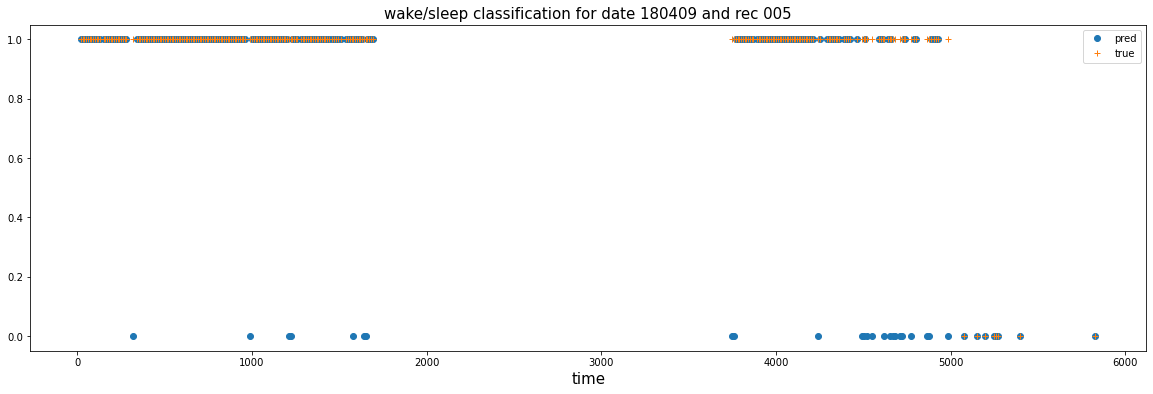

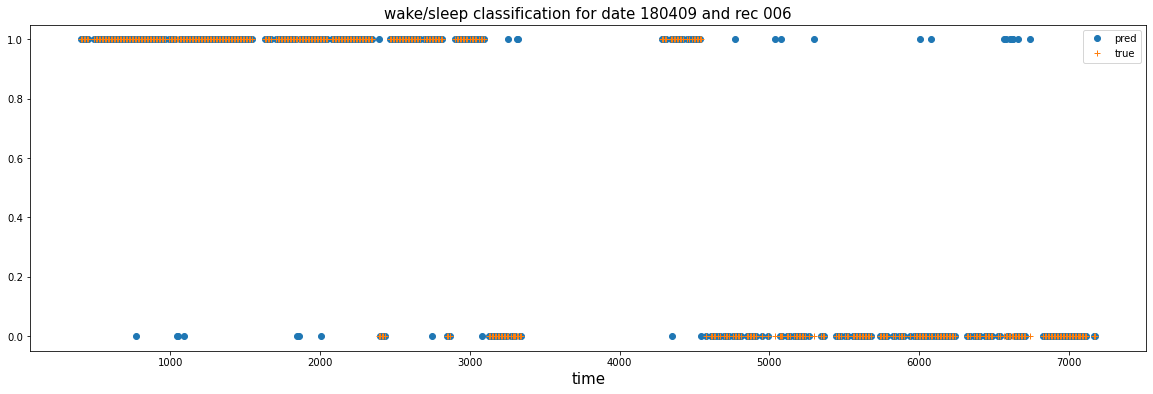

In [10]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.7073360085487366, train accuracy:0.7706176203451408, train percentage postive:0.5


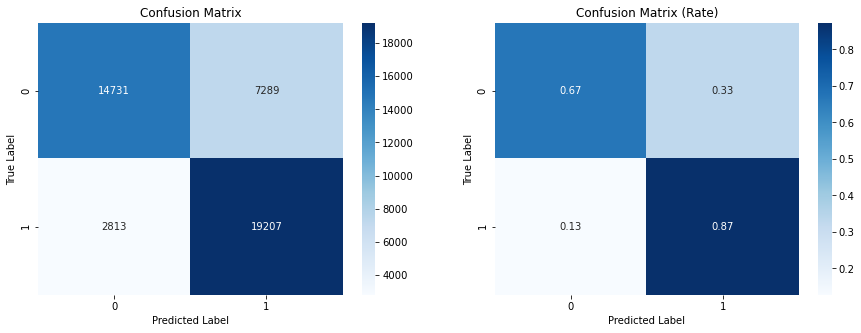

In [9]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'
time_window = 10

0
Train loss for epoch 0: 0.8938308954238892
Val loss for epoch 0: 2.1469595432281494
1
Train loss for epoch 1: 0.654201865196228
Val loss for epoch 1: 0.9263885617256165
2
Train loss for epoch 2: 0.4747644066810608
Val loss for epoch 2: 0.880195677280426
3
Train loss for epoch 3: 0.5295410752296448
Val loss for epoch 3: 0.7961999177932739
5
Train loss for epoch 5: 0.5021675229072571
Val loss for epoch 5: 0.5994006395339966


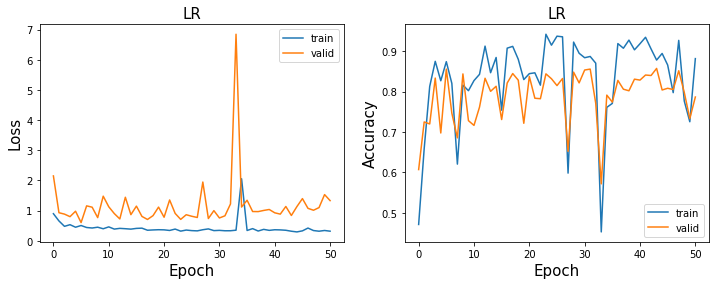

0
Train loss for epoch 0: 1.040509581565857
Val loss for epoch 0: 0.8542606830596924
1
Train loss for epoch 1: 0.6536657214164734
Val loss for epoch 1: 0.795822262763977
3
Train loss for epoch 3: 0.6208044290542603
Val loss for epoch 3: 0.6142364740371704
9
Train loss for epoch 9: 0.5841886401176453
Val loss for epoch 9: 0.5977611541748047
22
Train loss for epoch 22: 0.624082624912262
Val loss for epoch 22: 0.5943447947502136
26
Train loss for epoch 26: 0.6077079176902771
Val loss for epoch 26: 0.5560908317565918
47
Train loss for epoch 47: 0.6787789463996887
Val loss for epoch 47: 0.5043233633041382


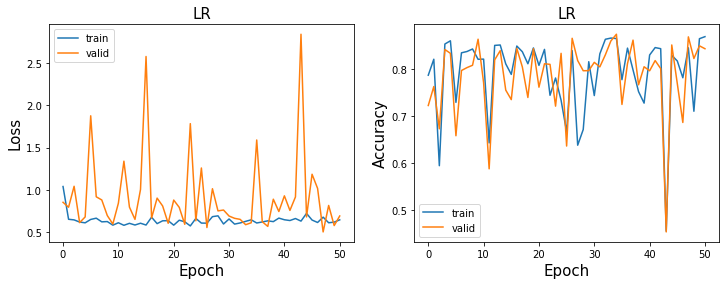

0
Train loss for epoch 0: 0.8661767840385437
Val loss for epoch 0: 0.5356187224388123
6
Train loss for epoch 6: 0.6638919115066528
Val loss for epoch 6: 0.49036598205566406
17
Train loss for epoch 17: 0.6650704741477966
Val loss for epoch 17: 0.4594971239566803


In [ ]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

0
Train loss for epoch 0: 0.9121711850166321
Val loss for epoch 0: 2.0439858436584473
1
Train loss for epoch 1: 0.8584936261177063
Val loss for epoch 1: 1.3860809803009033
2
Train loss for epoch 2: 0.6812836527824402
Val loss for epoch 2: 1.1066499948501587
3
Train loss for epoch 3: 0.6274129152297974
Val loss for epoch 3: 0.6123805046081543
8
Train loss for epoch 8: 0.6340906023979187
Val loss for epoch 8: 0.5861827731132507
9
Train loss for epoch 9: 0.6430120468139648
Val loss for epoch 9: 0.5838546752929688
10
Train loss for epoch 10: 0.6022667288780212
Val loss for epoch 10: 0.5435635447502136
26
Train loss for epoch 26: 0.6193409562110901
Val loss for epoch 26: 0.5092241168022156


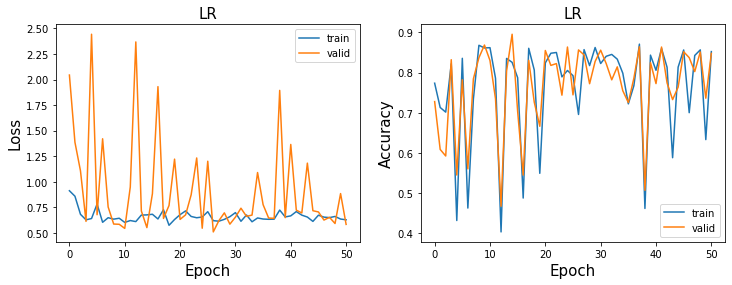

In [4]:
min_val_loss = 100
for alpha in [100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

In [4]:
best_alpha, best_epoch = 100, 17 # optimal when I set alpha=100 and trained the model for the FIRST (unfinished) time

val loss:0.4594971239566803, val accuracy:0.8787009063444109, val percentage postive:0.8261329531669617


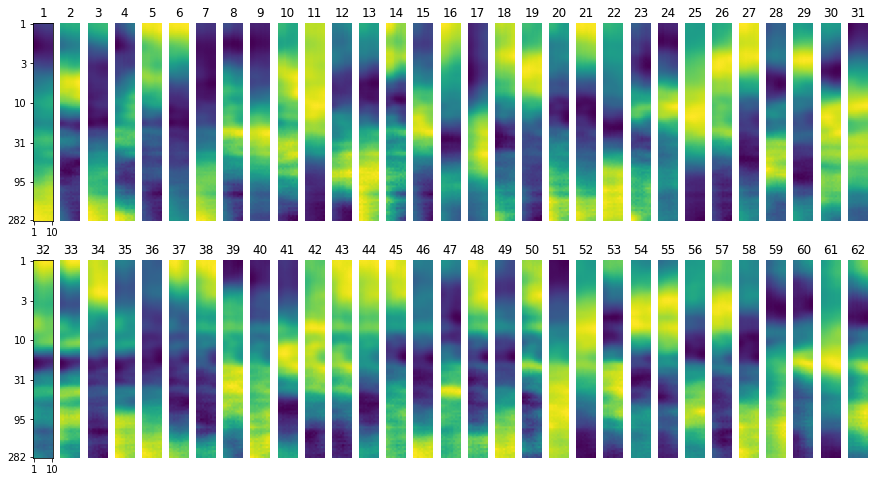

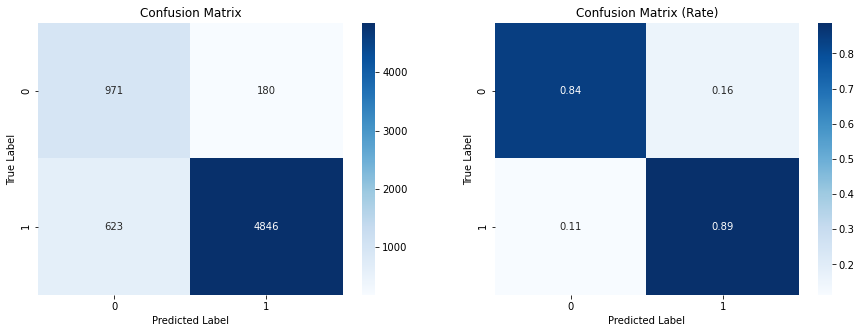

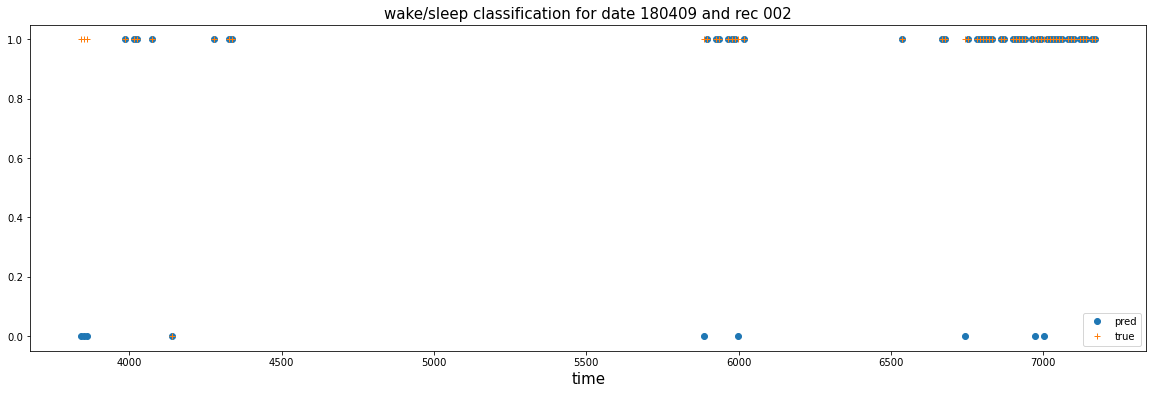

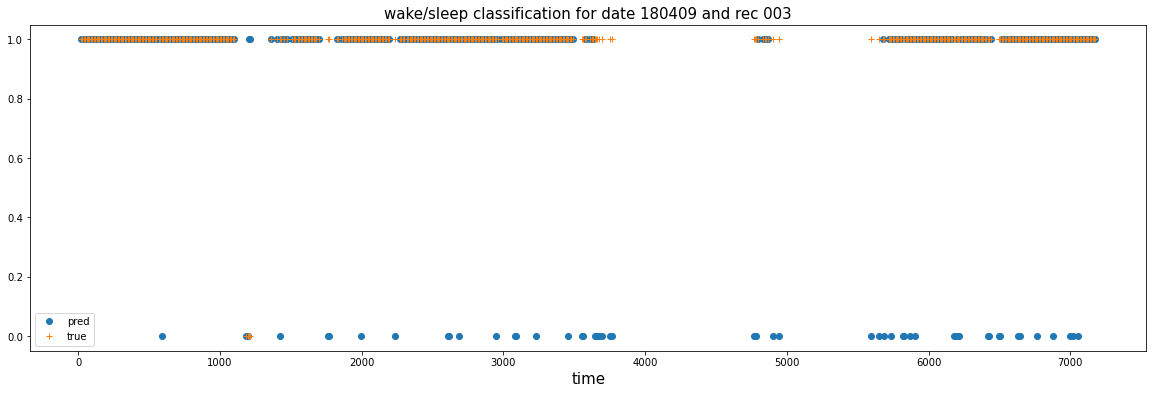

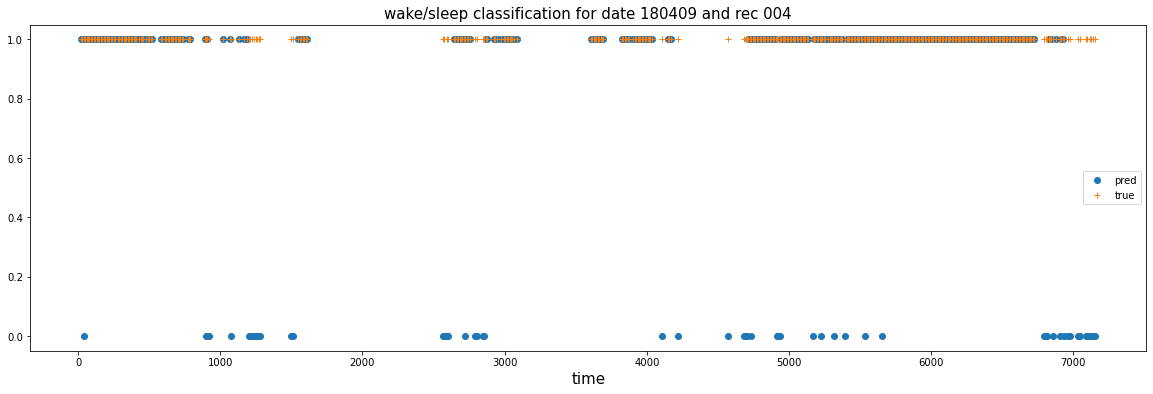

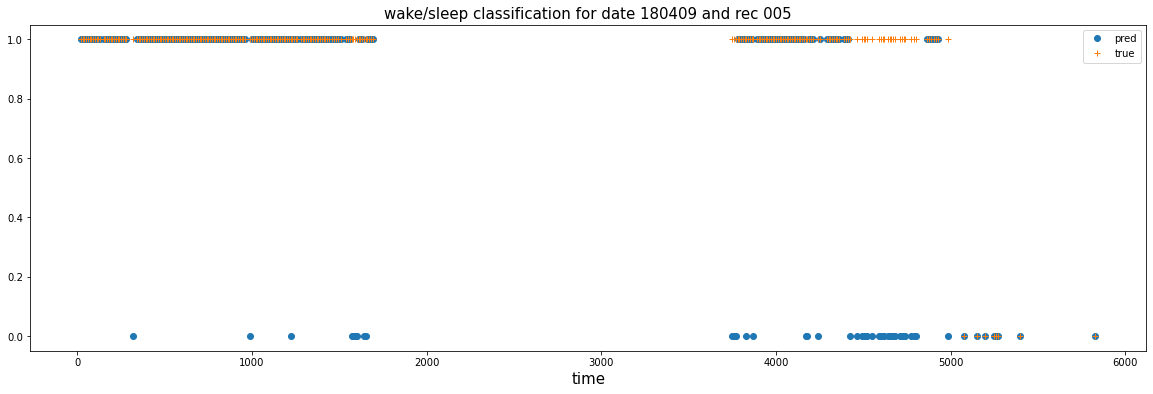

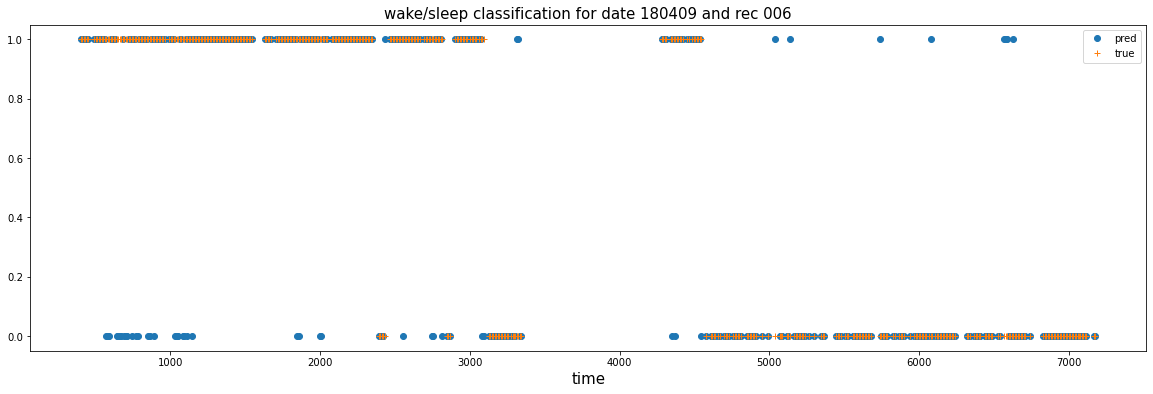

In [5]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.6402511596679688, train accuracy:0.8504314259763851, train percentage postive:0.5


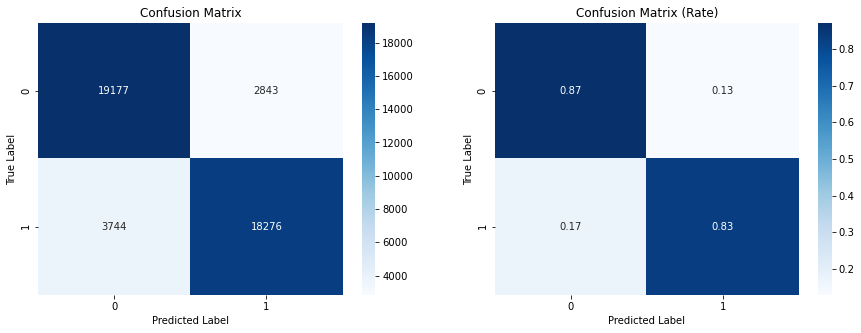

In [7]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

### Fixed Time Window = 10s, Skip Codes Below
### LR, 62CH, 5S

In [14]:
CH = 'all'
time_window = 5
device = torch.device('cuda')

val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_5s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['180327', '180329'], test dates: ['180330', '180331']
val instances: 13272, val imbalance: 0.7787824273109436
test instances: 13244, test imbalance: 0.7352763414382935
train instances: 41068, train imbalance: 0.5


#### Without regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.5049217343330383
Val loss for epoch 0: 0.45709455013275146


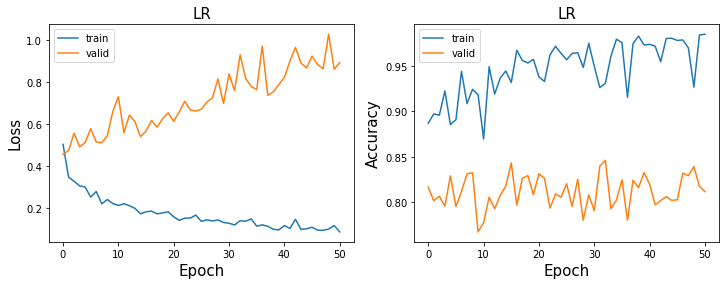

In [62]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.45709455013275146, val accuracy:0.8166817359855335, val percentage postive:0.7787824273109436


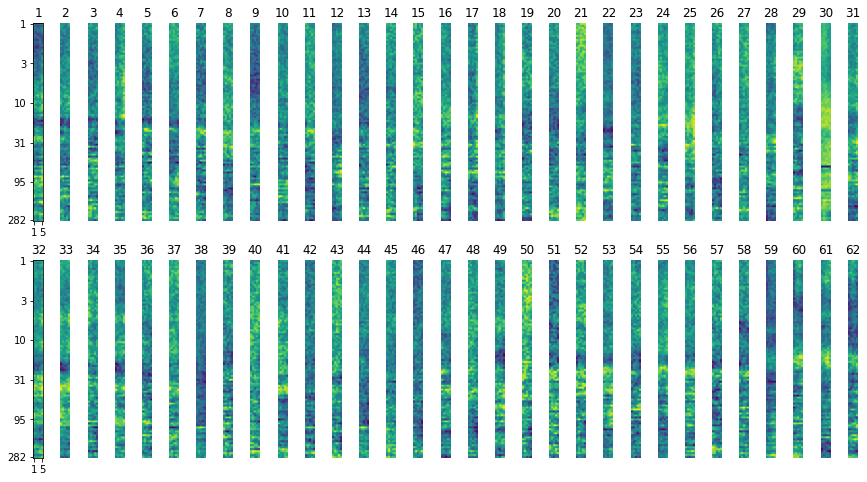

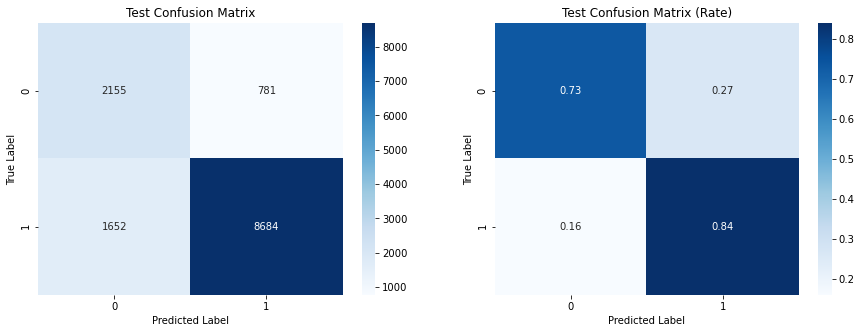

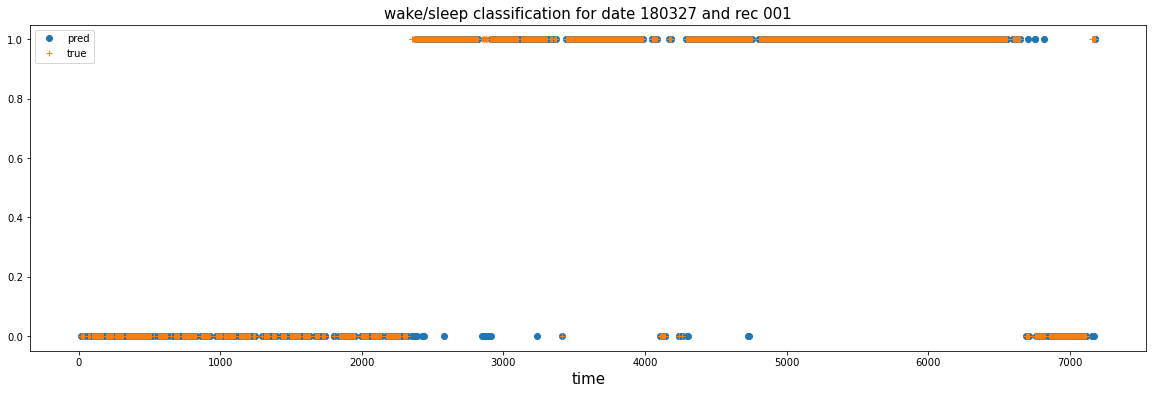

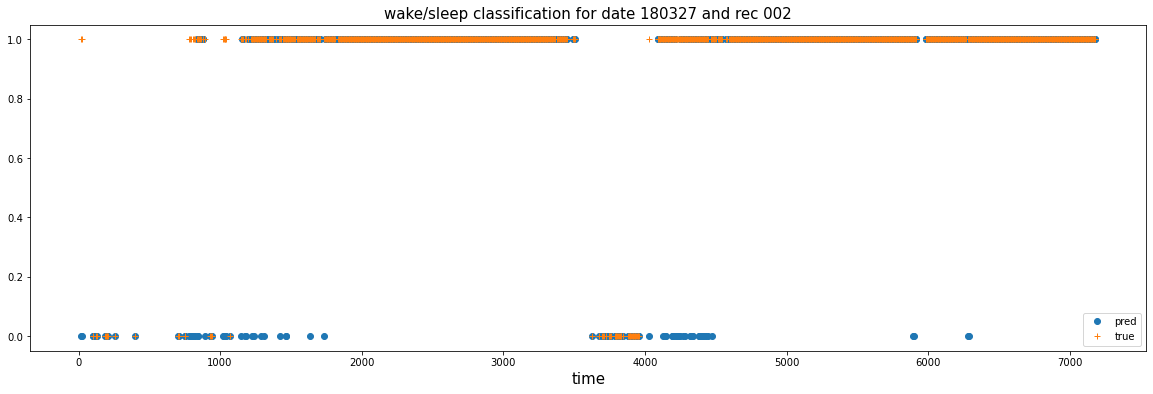

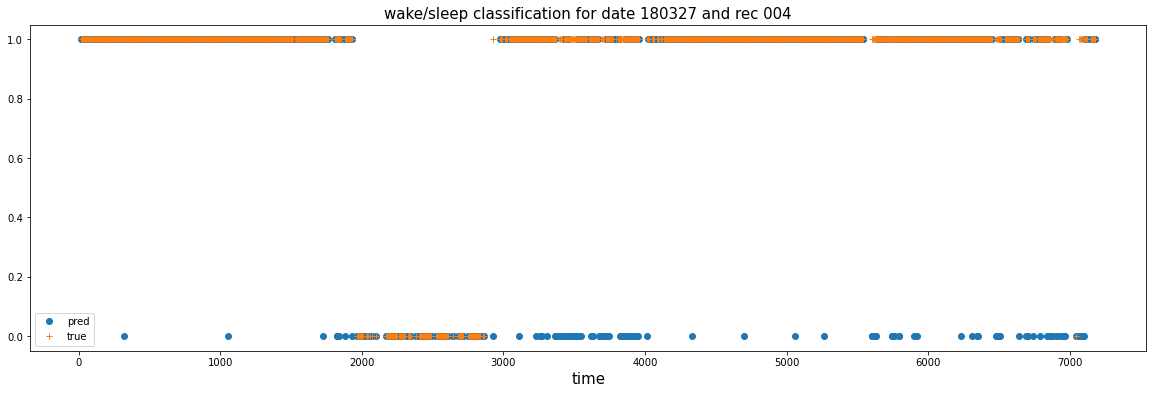

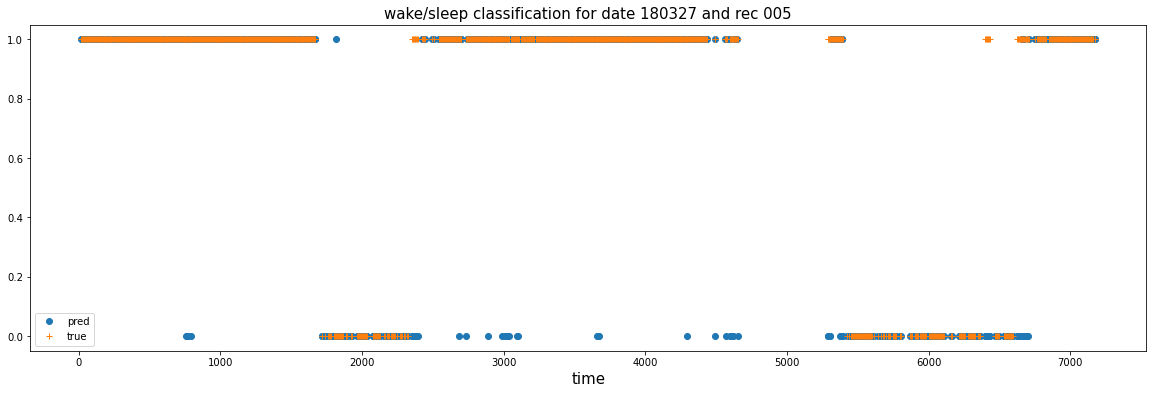

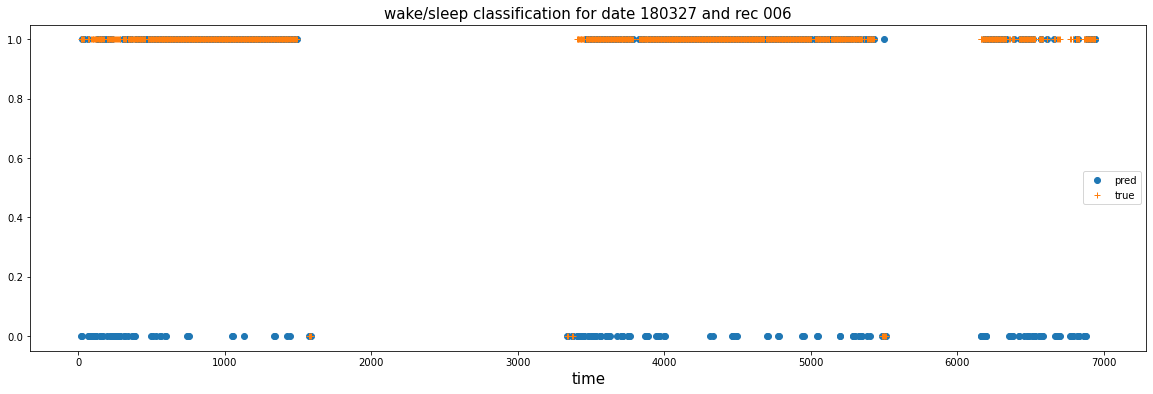

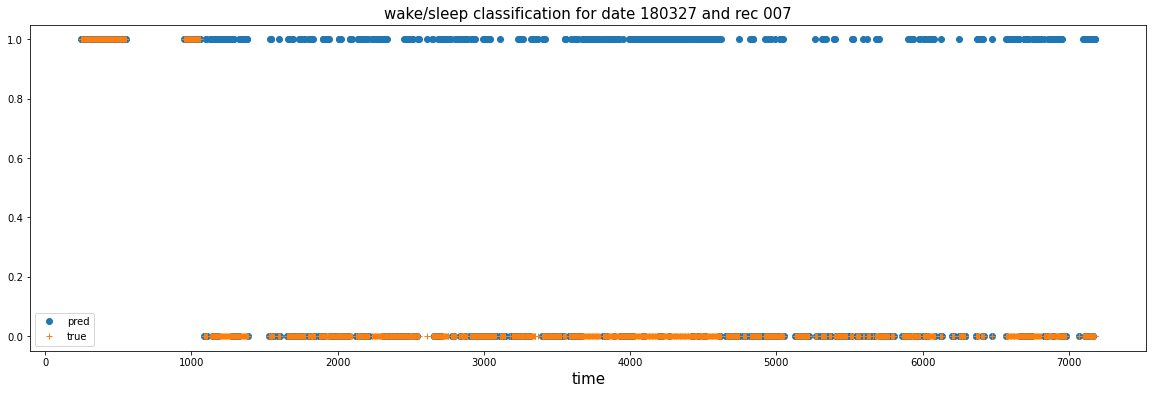

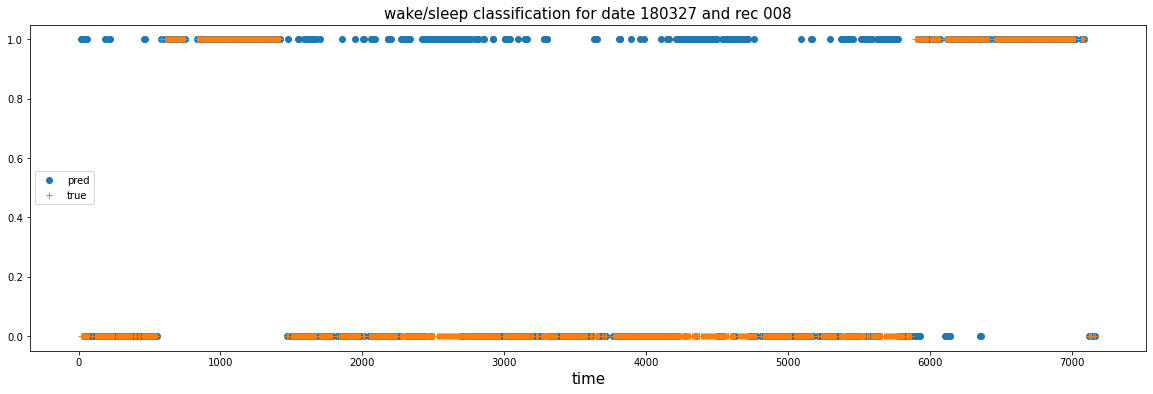

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.08807075023651123, train accuracy:0.9798870166553034, train percentage postive:0.5


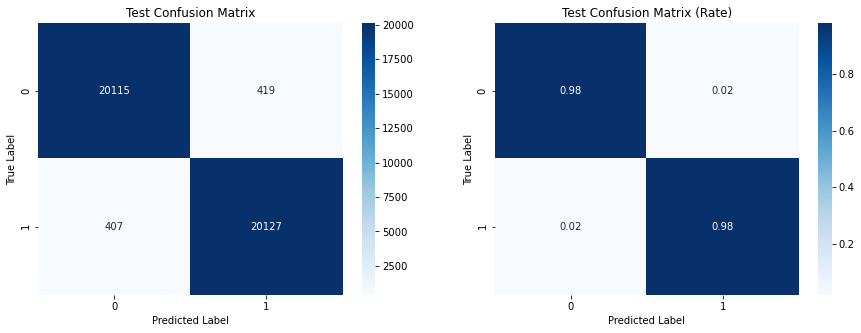

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [7]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.5082836151123047
Val loss for epoch 0: 0.5350350737571716
2
Train loss for epoch 2: 0.329218327999115
Val loss for epoch 2: 0.5083081126213074
3
Train loss for epoch 3: 0.32624271512031555
Val loss for epoch 3: 0.492893248796463


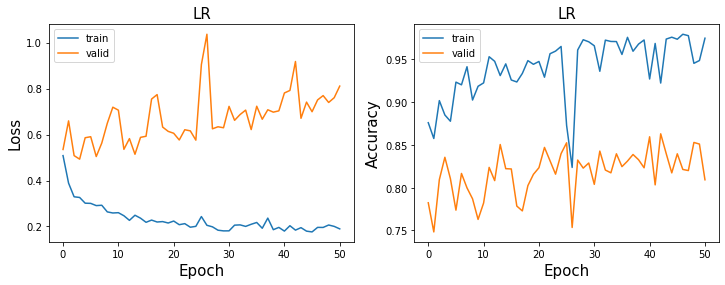

0
Train loss for epoch 0: 0.6597583889961243
Val loss for epoch 0: 0.7763242125511169
1
Train loss for epoch 1: 0.6025110483169556
Val loss for epoch 1: 0.5766419172286987
2
Train loss for epoch 2: 0.5571439266204834
Val loss for epoch 2: 0.5036622285842896
5
Train loss for epoch 5: 0.5644950866699219
Val loss for epoch 5: 0.4759393036365509
9
Train loss for epoch 9: 0.5725904107093811
Val loss for epoch 9: 0.4668348431587219
19
Train loss for epoch 19: 0.5479883551597595
Val loss for epoch 19: 0.4520978033542633
29
Train loss for epoch 29: 0.5671103596687317
Val loss for epoch 29: 0.4517136812210083


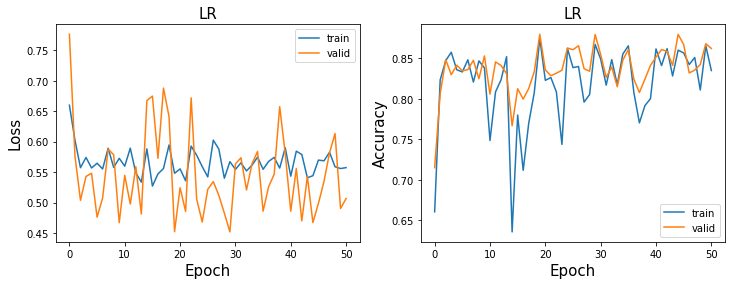

0
Train loss for epoch 0: 0.725829541683197
Val loss for epoch 0: 0.6109916567802429
1
Train loss for epoch 1: 0.6394141912460327
Val loss for epoch 1: 0.5607039928436279
3
Train loss for epoch 3: 0.6107273101806641
Val loss for epoch 3: 0.5351472496986389
5
Train loss for epoch 5: 0.6069586277008057
Val loss for epoch 5: 0.5004533529281616
8
Train loss for epoch 8: 0.6226311326026917
Val loss for epoch 8: 0.49927353858947754
11
Train loss for epoch 11: 0.6038218140602112
Val loss for epoch 11: 0.4832307696342468
20
Train loss for epoch 20: 0.6149115562438965
Val loss for epoch 20: 0.4650472402572632


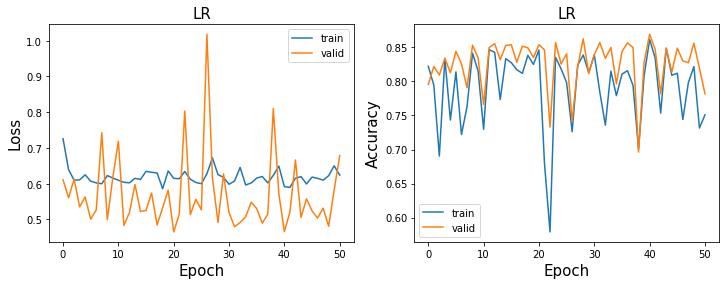

In [8]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.4517136812210083, val accuracy:0.8793701024713683, val percentage postive:0.7787824273109436


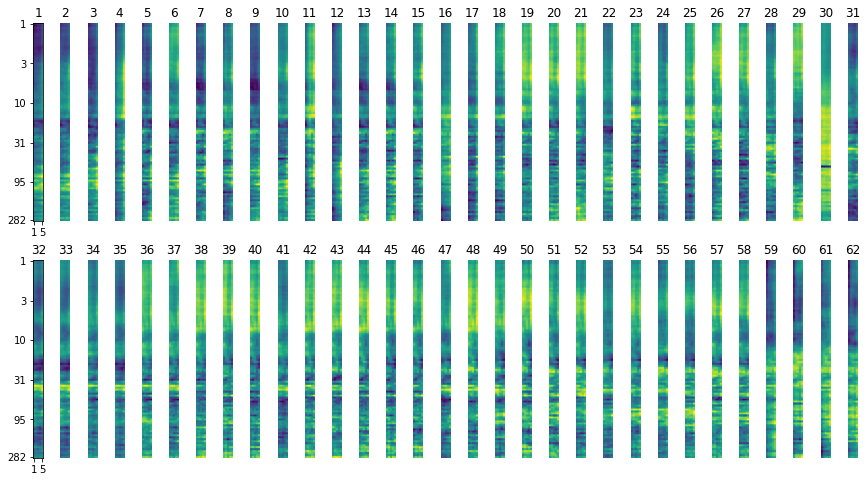

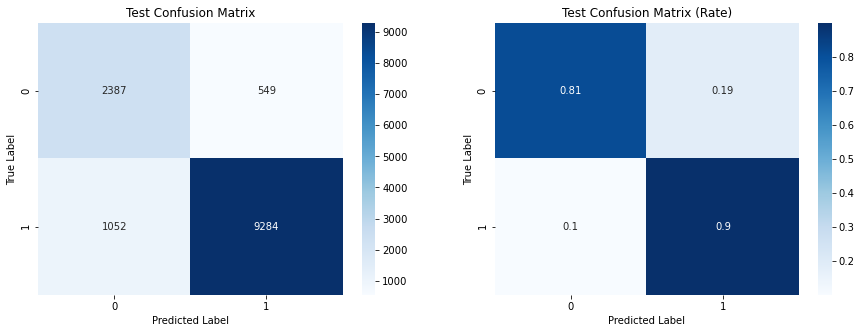

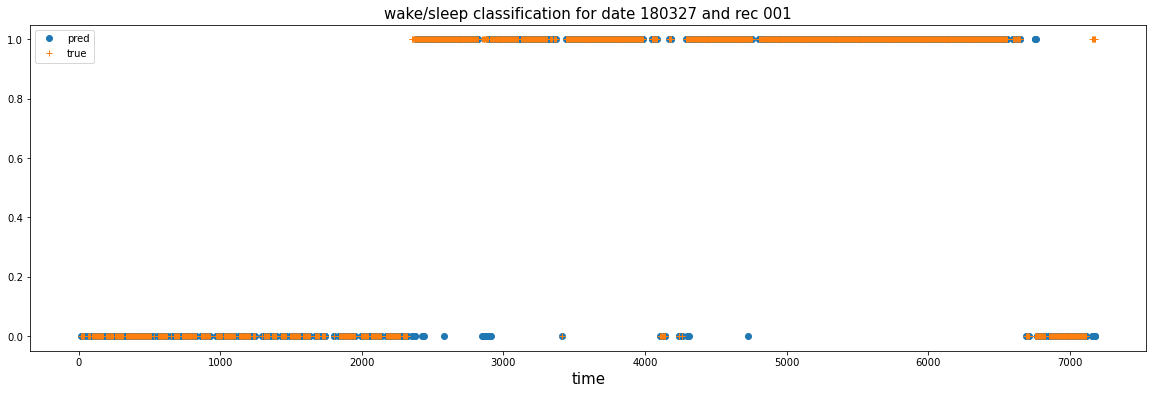

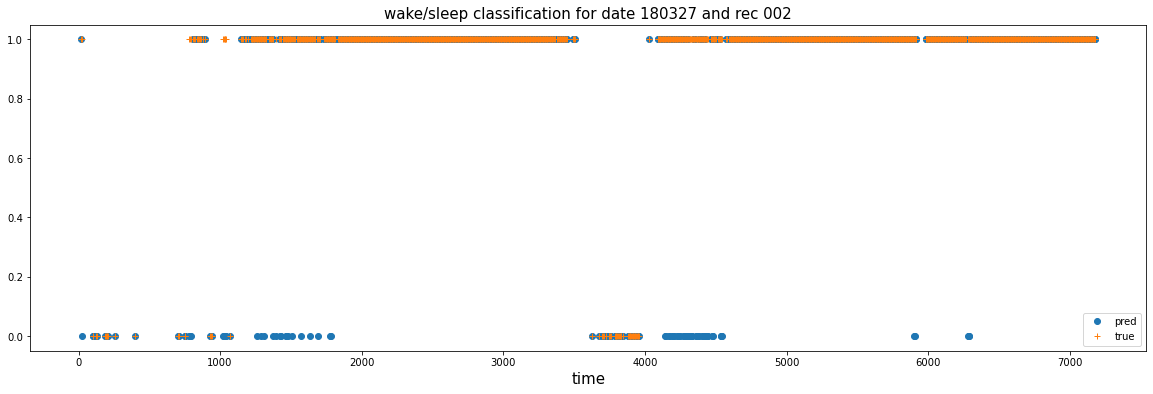

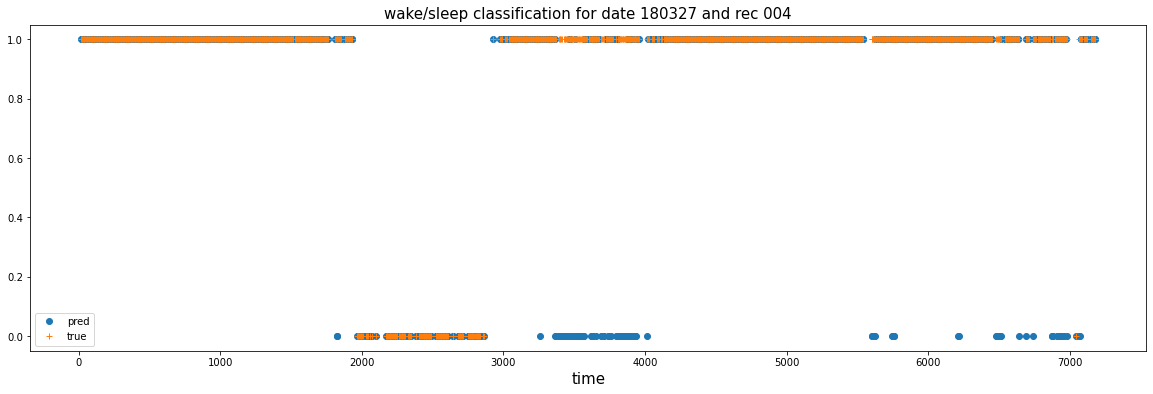

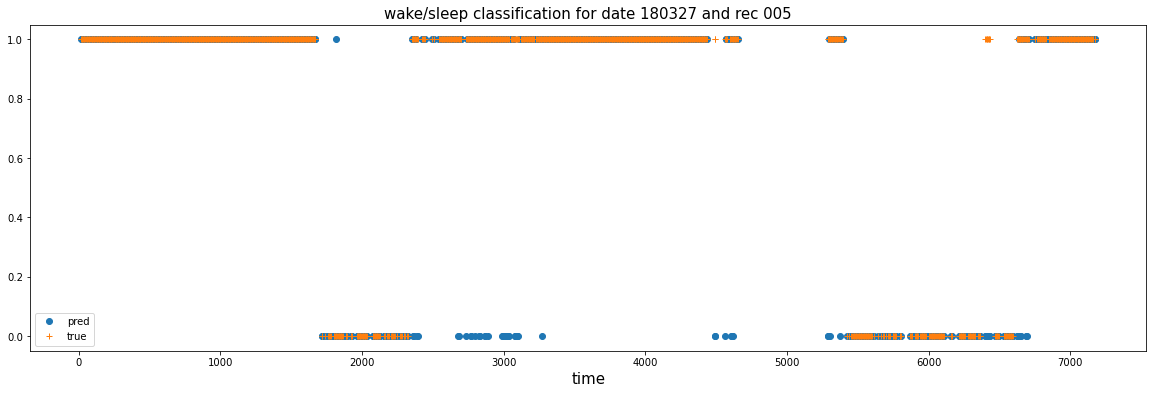

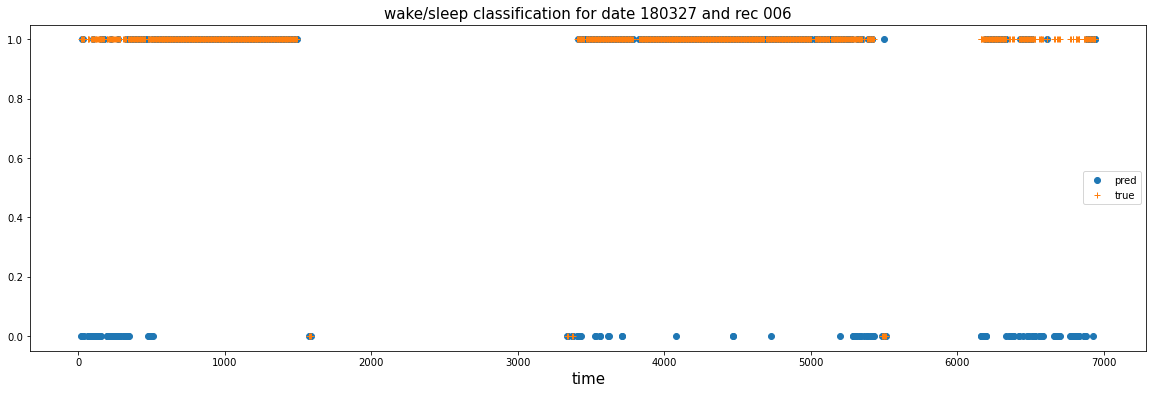

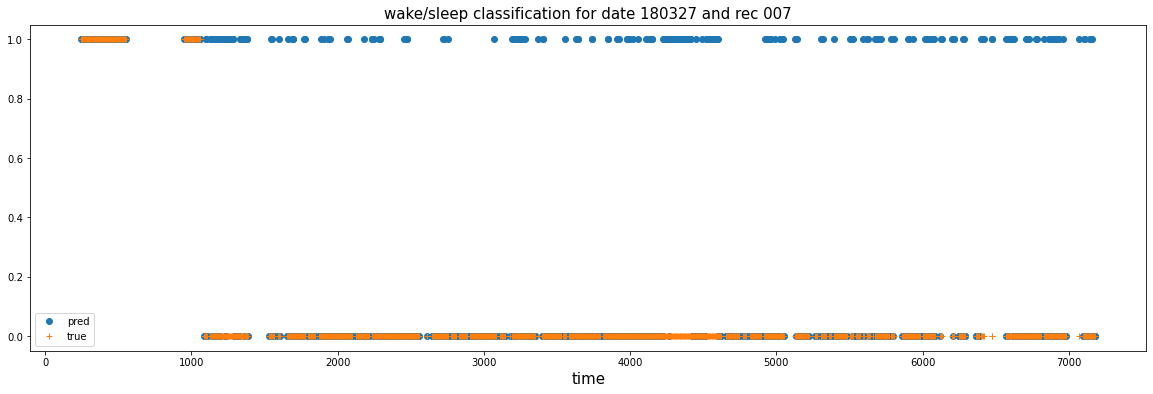

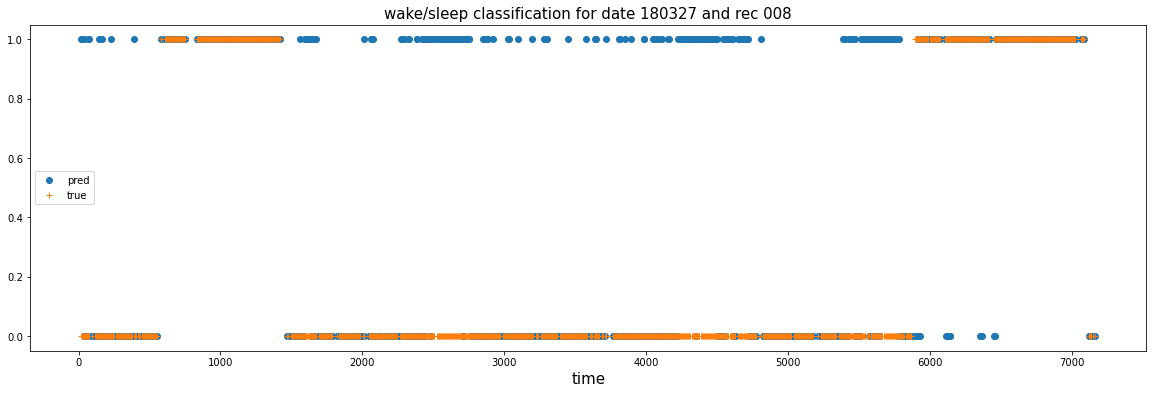

In [9]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.736582338809967, train accuracy:0.7508522450569787, train percentage postive:0.5


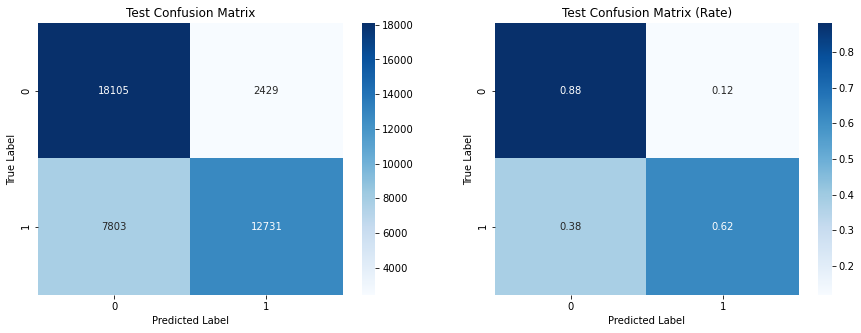

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 0.4929482340812683
Val loss for epoch 0: 0.4725939929485321


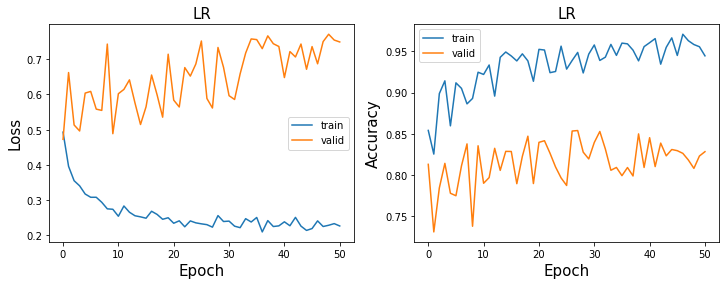

0
Train loss for epoch 0: 0.5969903469085693
Val loss for epoch 0: 0.5214177966117859
1
Train loss for epoch 1: 0.49316632747650146
Val loss for epoch 1: 0.48322010040283203
5
Train loss for epoch 5: 0.45493564009666443
Val loss for epoch 5: 0.4556831419467926
8
Train loss for epoch 8: 0.4385402798652649
Val loss for epoch 8: 0.4491444230079651
23
Train loss for epoch 23: 0.4720892906188965
Val loss for epoch 23: 0.4332025647163391


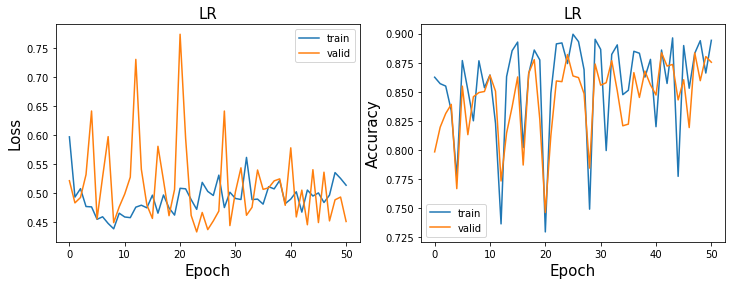

0
Train loss for epoch 0: 0.6056838631629944
Val loss for epoch 0: 0.5279271006584167
1
Train loss for epoch 1: 0.49098891019821167
Val loss for epoch 1: 0.504608690738678
4
Train loss for epoch 4: 0.517510175704956
Val loss for epoch 4: 0.47482648491859436
11
Train loss for epoch 11: 0.5076421499252319
Val loss for epoch 11: 0.4738823175430298
13
Train loss for epoch 13: 0.4973599314689636
Val loss for epoch 13: 0.4289557635784149
15
Train loss for epoch 15: 0.4899548590183258
Val loss for epoch 15: 0.42891696095466614
33
Train loss for epoch 33: 0.5387601852416992
Val loss for epoch 33: 0.42052894830703735


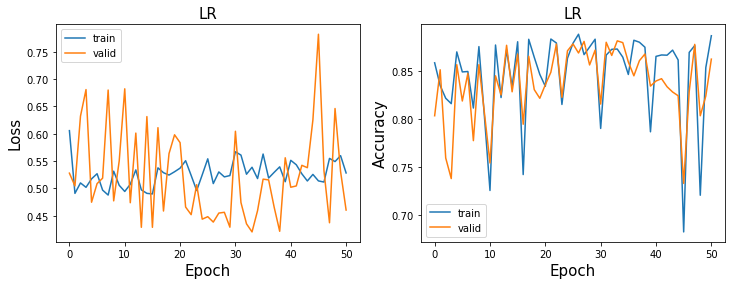

In [4]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.42052894830703735, val accuracy:0.88208257986739, val percentage postive:0.7787824273109436


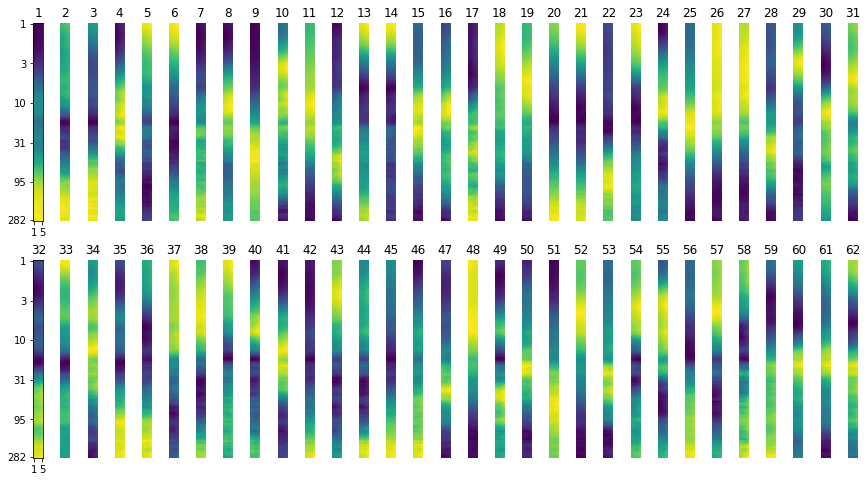

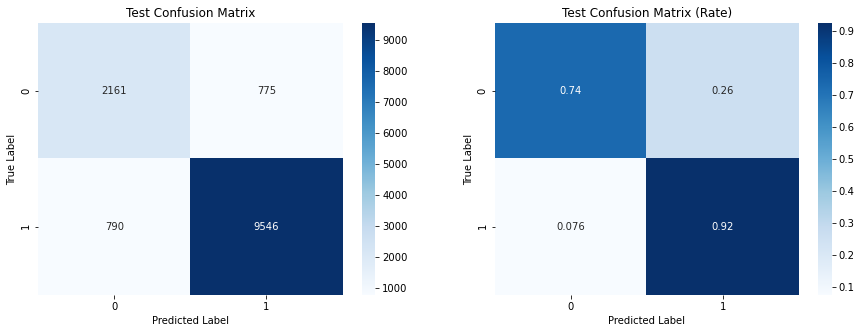

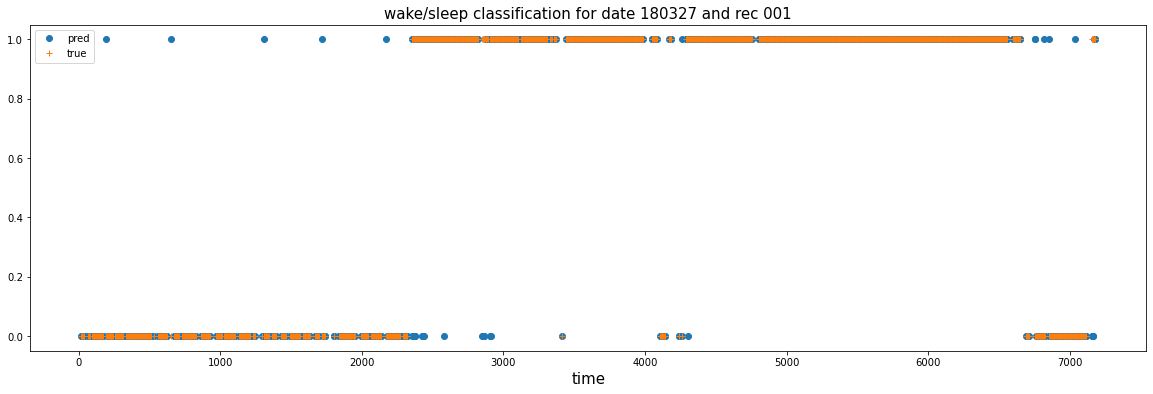

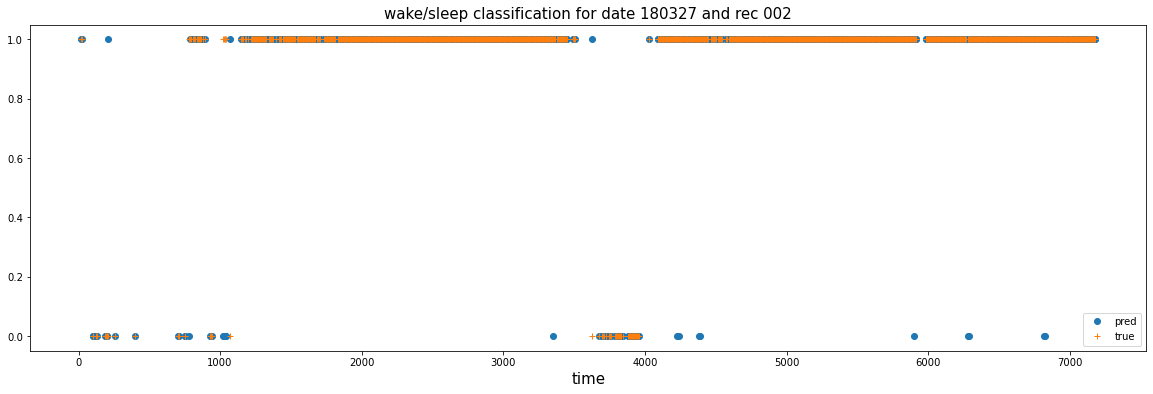

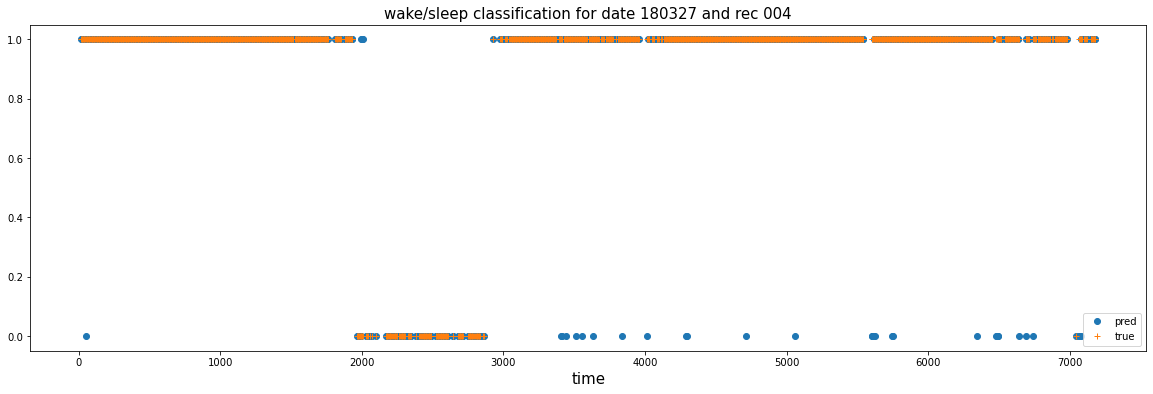

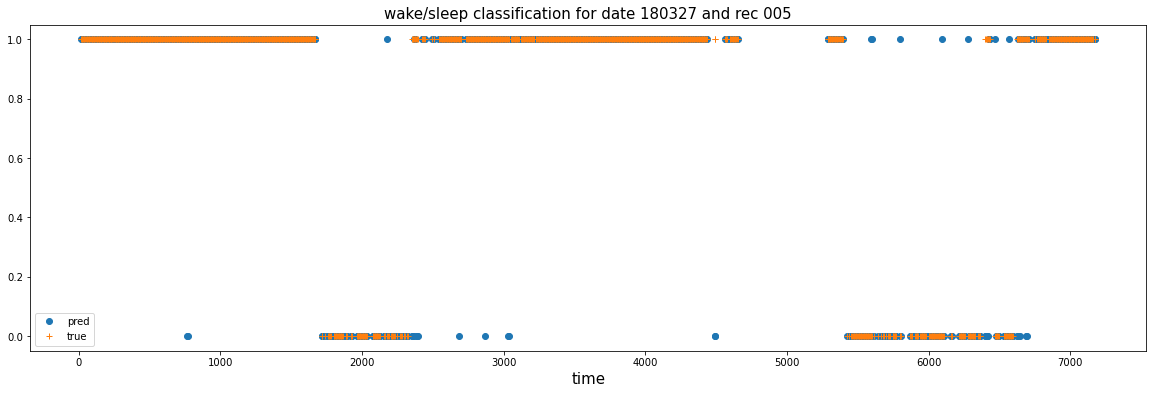

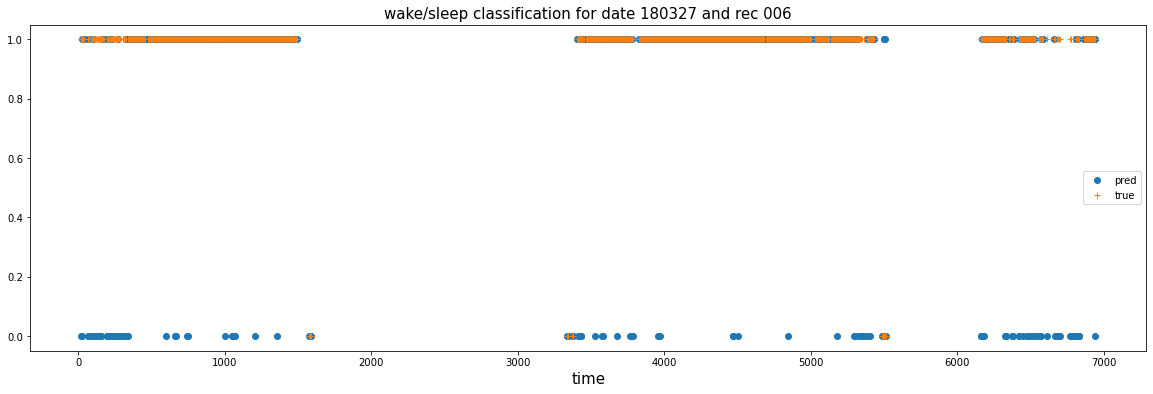

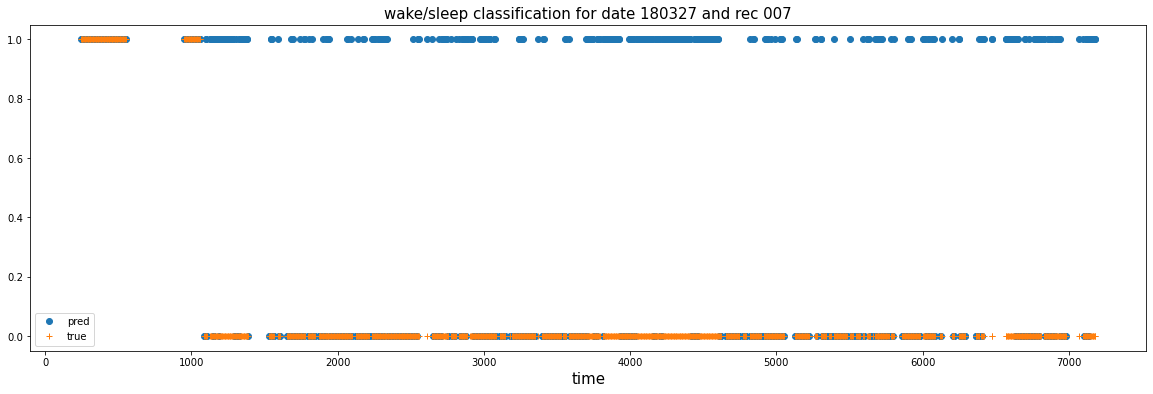

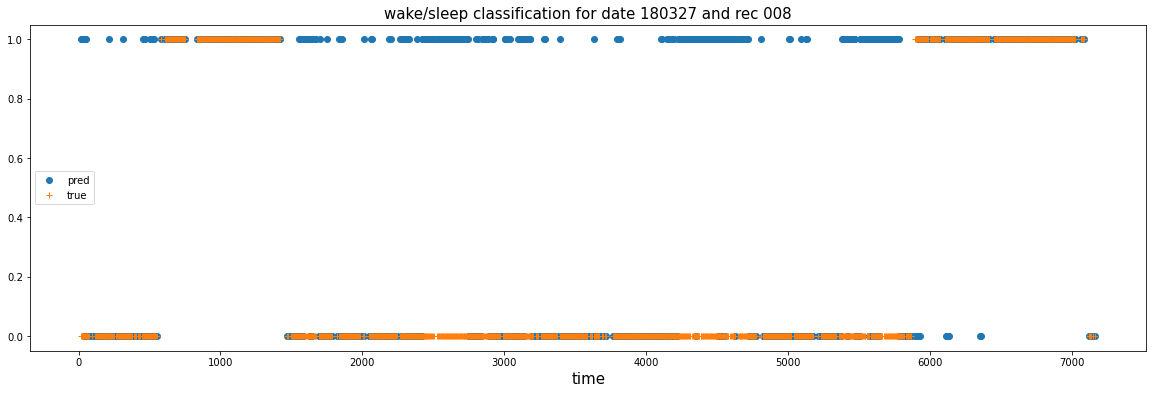

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.448866605758667, train accuracy:0.8874306029025032, train percentage postive:0.5


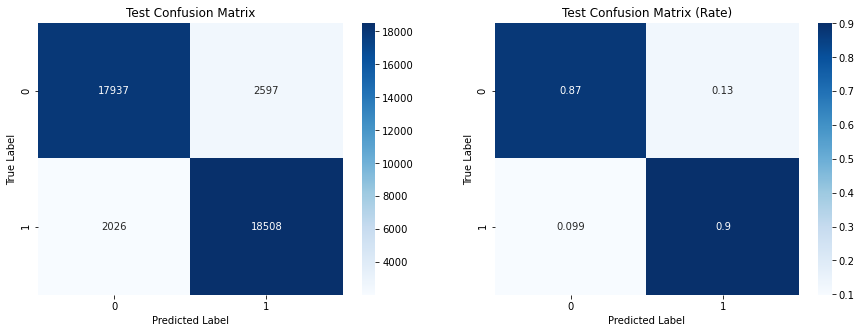

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

### LR, 62CH, 15S

In [2]:
CH = 'all'
time_window = 15
device = torch.device('cuda')

val_dates = ['180327']
test_dates = ['180330']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_15s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=256)

val dates: ['180327'], test dates: ['180330']
val instances: 807, val imbalance: 0.0768277570605278
test instances: 703, test imbalance: 0.10953058302402496
train instances: 2934, train imbalance: 0.5


In [41]:
# CH = 'all'
# time_window = 15
# device = torch.device('cuda')

# val_dates = ['180324', '180330']
# test_dates = ['180325', '180327']
# bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
# load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_15s_2/'
# save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

# test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
# train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
# train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=256)

#### Without regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 7.3623785972595215
Val loss for epoch 0: 8.354308128356934
1
Train loss for epoch 1: 8.883780479431152
Val loss for epoch 1: 7.8880205154418945
2
Train loss for epoch 2: 8.040365219116211
Val loss for epoch 2: 7.6427998542785645
3
Train loss for epoch 3: 5.689975261688232
Val loss for epoch 3: 6.753273010253906
4
Train loss for epoch 4: 2.088932514190674
Val loss for epoch 4: 3.512111186981201
7
Train loss for epoch 7: 0.5362054705619812
Val loss for epoch 7: 2.4628188610076904
8
Train loss for epoch 8: 0.4683822989463806
Val loss for epoch 8: 1.9404903650283813
9
Train loss for epoch 9: 0.3243051767349243
Val loss for epoch 9: 1.130286455154419
10
Train loss for epoch 10: 0.2108927220106125
Val loss for epoch 10: 1.0912070274353027
11
Train loss for epoch 11: 0.20146909356117249
Val loss for epoch 11: 0.7431933283805847
18
Train loss for epoch 18: 0.03813327103853226
Val loss for epoch 18: 0.6386033892631531


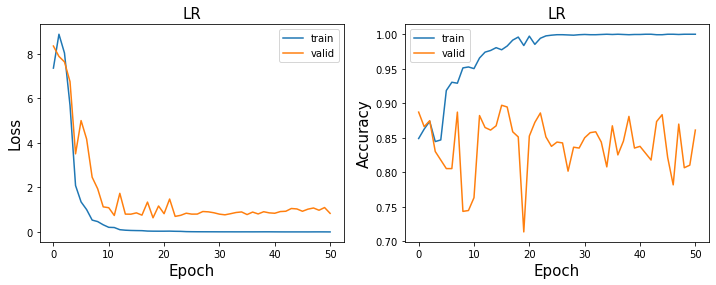

In [4]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.6386033892631531, val accuracy:0.8513011152416357, val percentage postive:0.0768277570605278


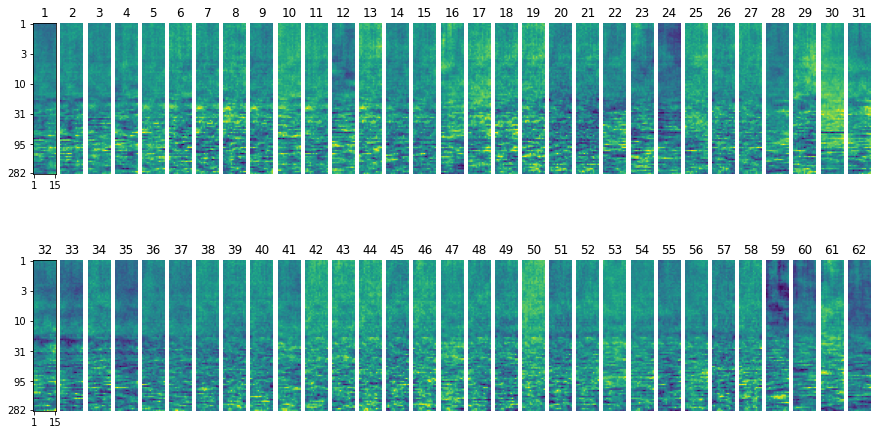

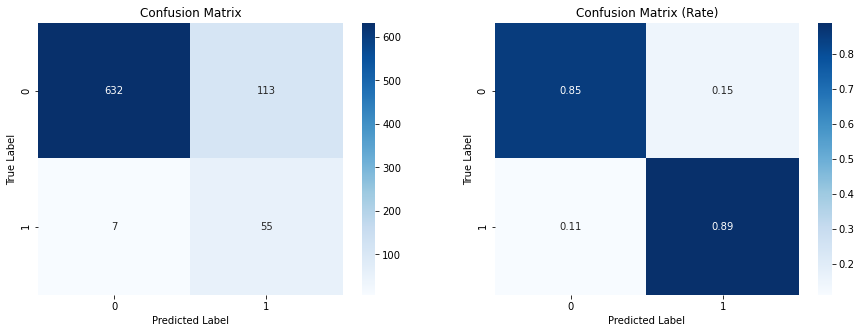

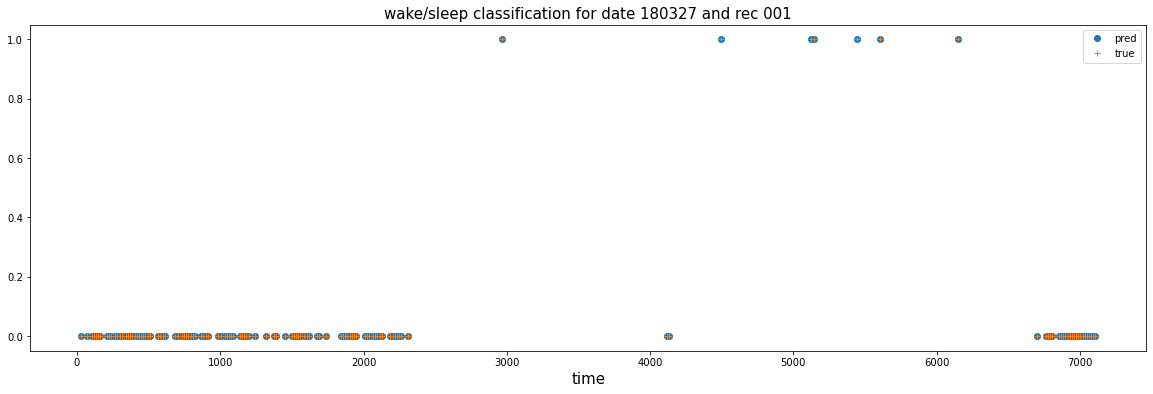

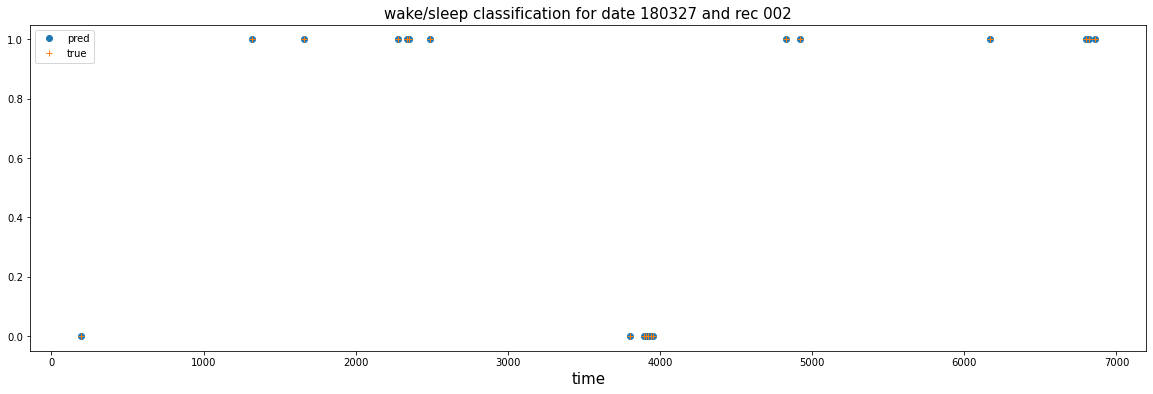

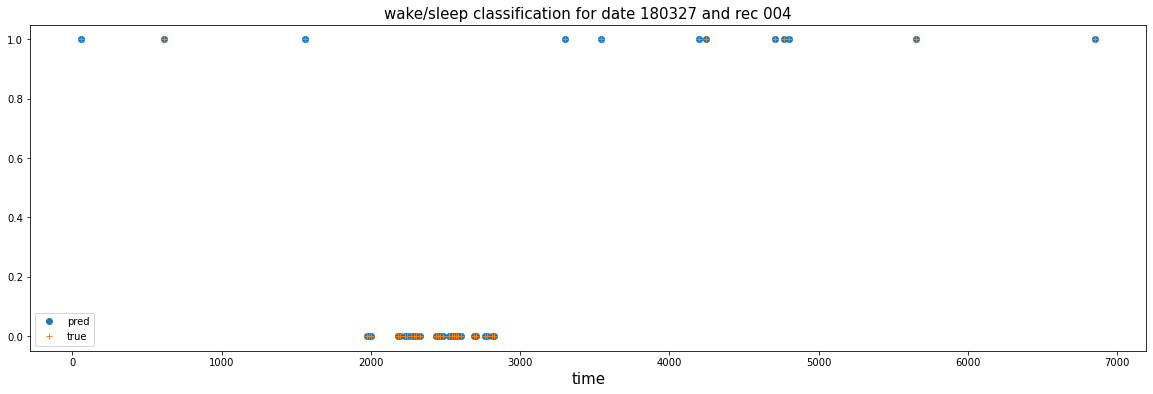

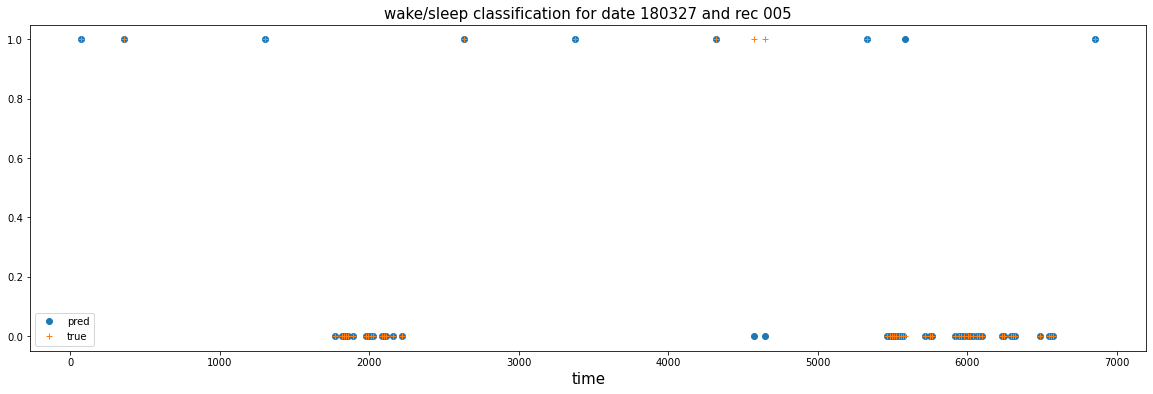

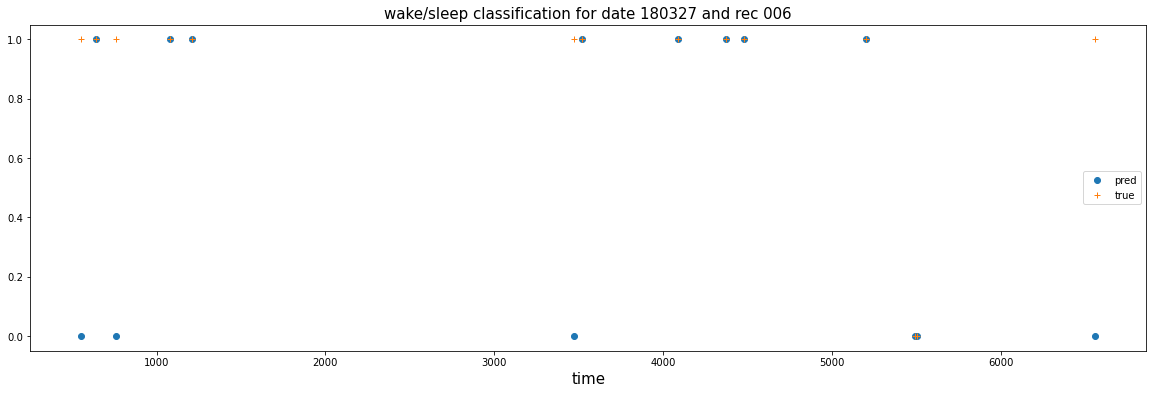

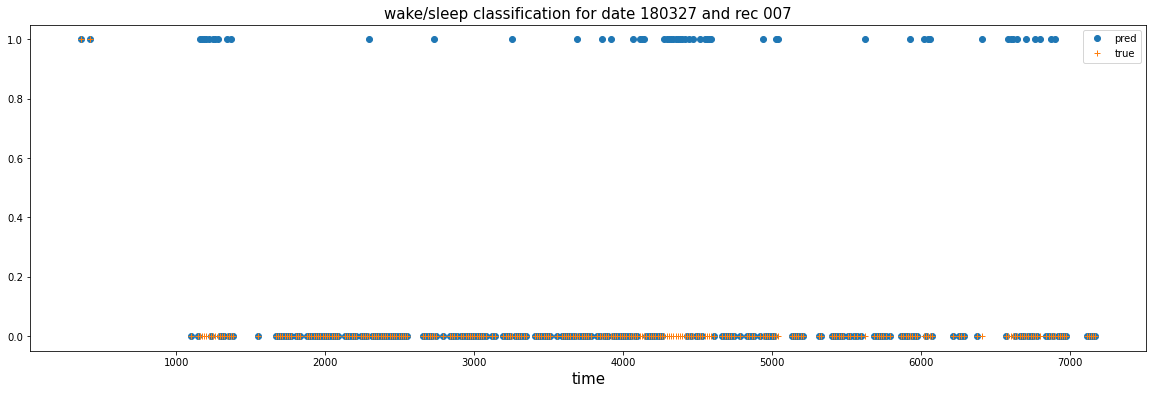

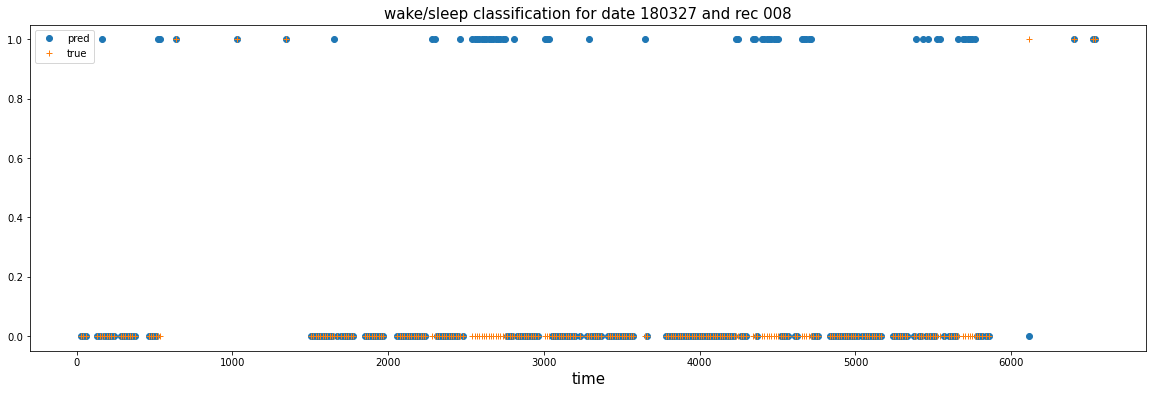

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.004001283552497625, train accuracy:1.0, train percentage postive:0.5


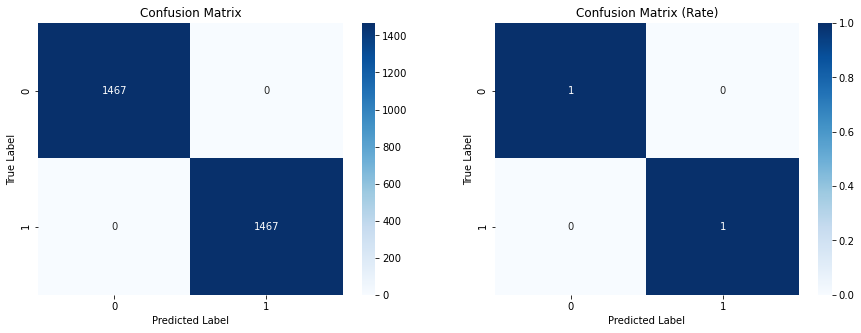

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [7]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 6.742123126983643
Val loss for epoch 0: 7.713152885437012
2
Train loss for epoch 2: 6.552579402923584
Val loss for epoch 2: 7.243968486785889
3
Train loss for epoch 3: 2.52925443649292
Val loss for epoch 3: 4.5471930503845215
5
Train loss for epoch 5: 0.9554158449172974
Val loss for epoch 5: 2.8371403217315674
6
Train loss for epoch 6: 0.47639256715774536
Val loss for epoch 6: 0.8898207545280457
11
Train loss for epoch 11: 0.10406990349292755
Val loss for epoch 11: 0.7101783752441406
24
Train loss for epoch 24: 0.02310832589864731
Val loss for epoch 24: 0.5841119289398193


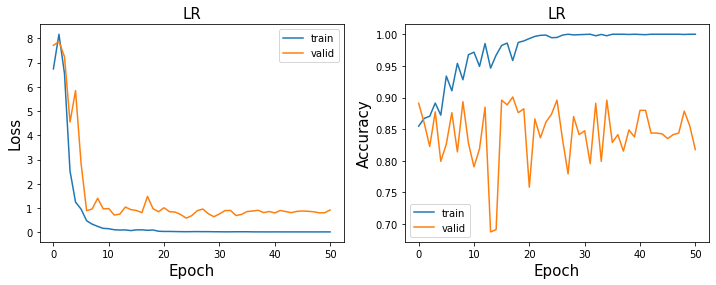

0
Train loss for epoch 0: 8.16971206665039
Val loss for epoch 0: 7.614139556884766
2
Train loss for epoch 2: 8.341407775878906
Val loss for epoch 2: 7.251531600952148
3
Train loss for epoch 3: 5.324763298034668
Val loss for epoch 3: 6.570837020874023
4
Train loss for epoch 4: 1.7969921827316284
Val loss for epoch 4: 5.064217567443848
5
Train loss for epoch 5: 1.516917109489441
Val loss for epoch 5: 2.067976474761963
6
Train loss for epoch 6: 0.7259712219238281
Val loss for epoch 6: 1.6132588386535645
9
Train loss for epoch 9: 0.5211003422737122
Val loss for epoch 9: 1.021061658859253
10
Train loss for epoch 10: 0.40800920128822327
Val loss for epoch 10: 0.885645866394043
12
Train loss for epoch 12: 0.32844215631484985
Val loss for epoch 12: 0.7042562961578369
13
Train loss for epoch 13: 0.32312583923339844
Val loss for epoch 13: 0.6663298010826111
31
Train loss for epoch 31: 0.2851581573486328
Val loss for epoch 31: 0.6294642090797424


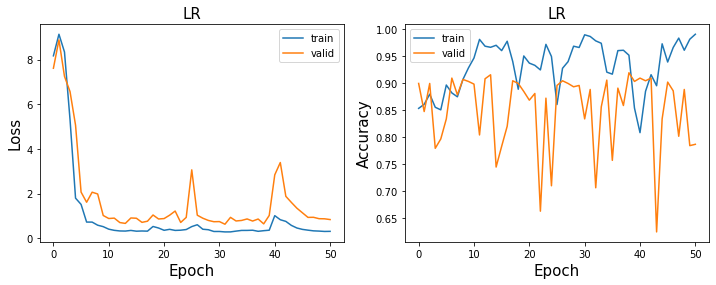

0
Train loss for epoch 0: 6.601210117340088
Val loss for epoch 0: 7.076709270477295
1
Train loss for epoch 1: 5.750747203826904
Val loss for epoch 1: 5.684140205383301
2
Train loss for epoch 2: 2.300185441970825
Val loss for epoch 2: 1.8012913465499878
4
Train loss for epoch 4: 0.975090503692627
Val loss for epoch 4: 1.0536150932312012
5
Train loss for epoch 5: 0.6516616344451904
Val loss for epoch 5: 0.8820650577545166
6
Train loss for epoch 6: 0.5310970544815063
Val loss for epoch 6: 0.8228191137313843
8
Train loss for epoch 8: 0.5179251432418823
Val loss for epoch 8: 0.6811643242835999
18
Train loss for epoch 18: 0.48008403182029724
Val loss for epoch 18: 0.6454691290855408
19
Train loss for epoch 19: 0.4097549319267273
Val loss for epoch 19: 0.6205943822860718
41
Train loss for epoch 41: 0.35477718710899353
Val loss for epoch 41: 0.5697904825210571


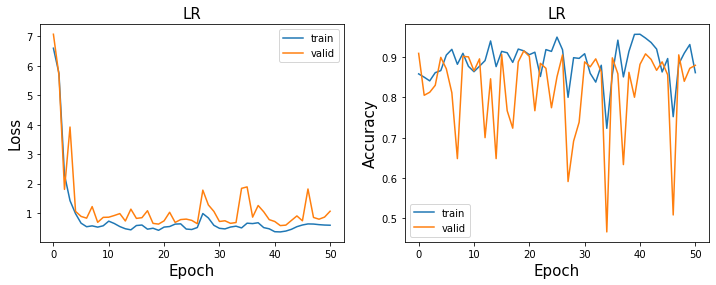

In [8]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.5697904825210571, val accuracy:0.9083023543990086, val percentage postive:0.0768277570605278


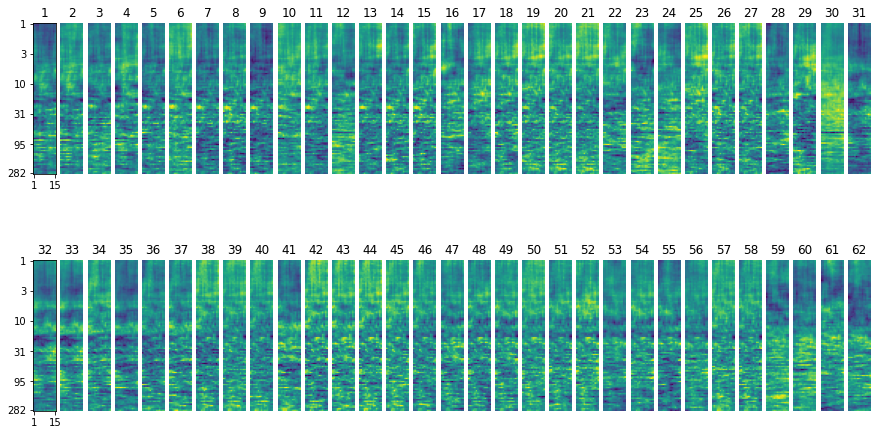

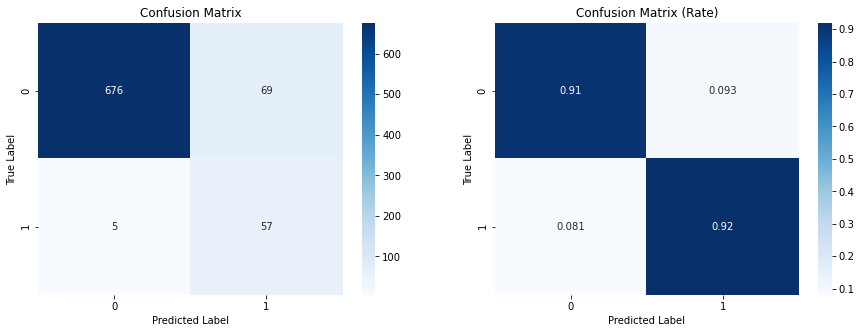

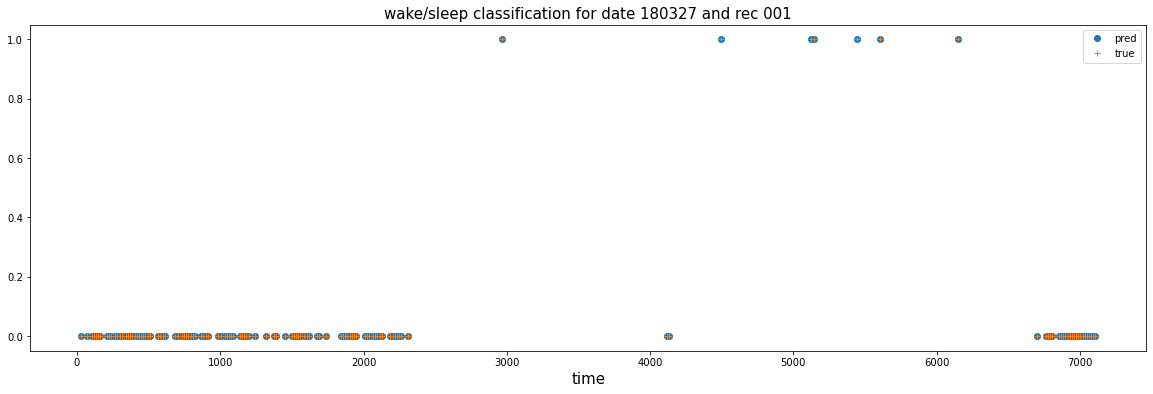

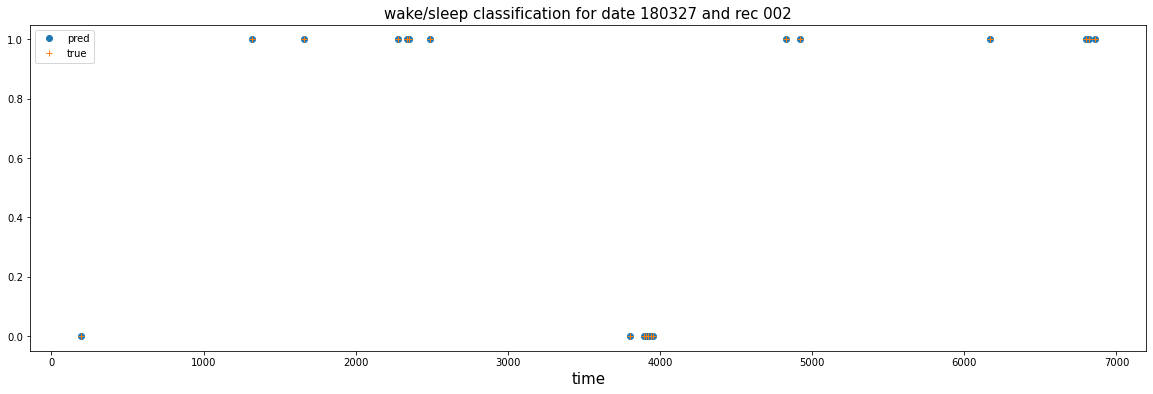

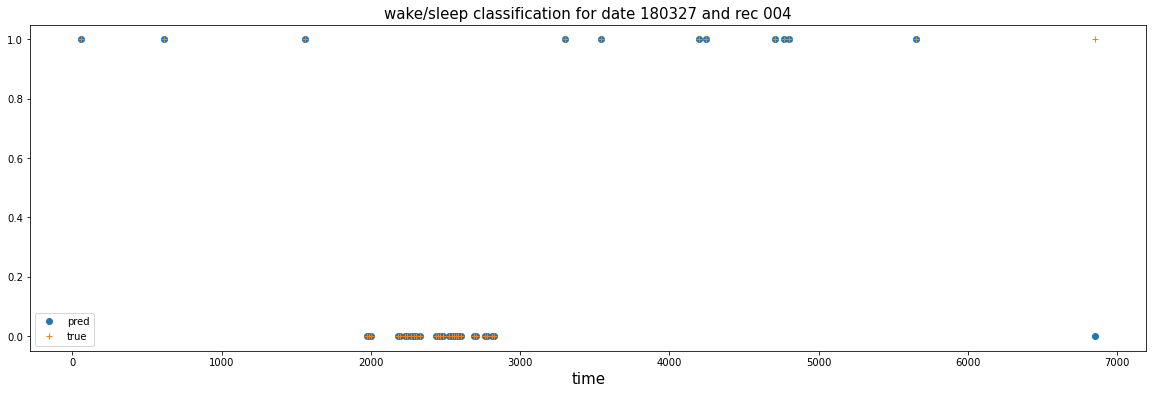

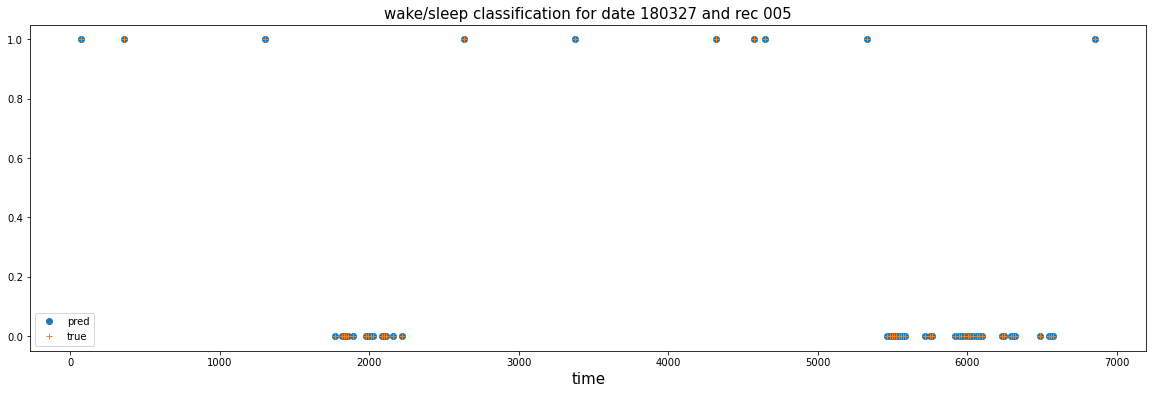

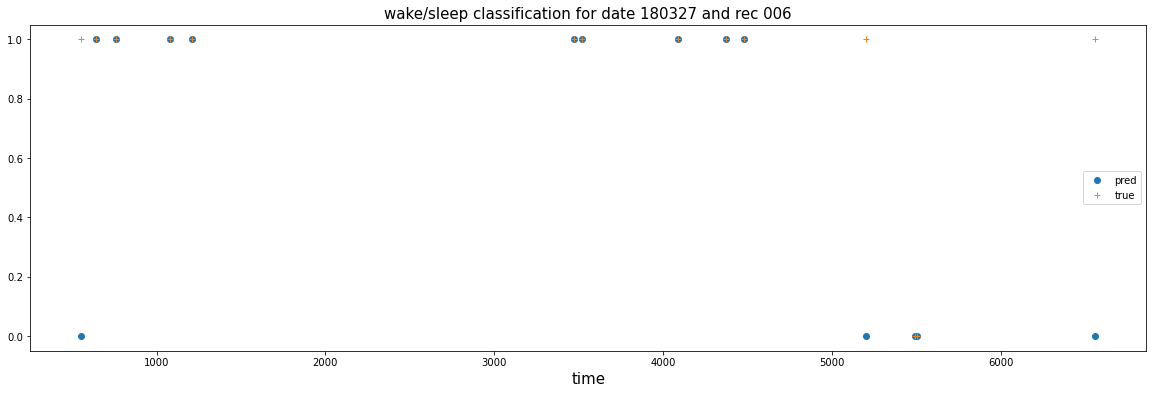

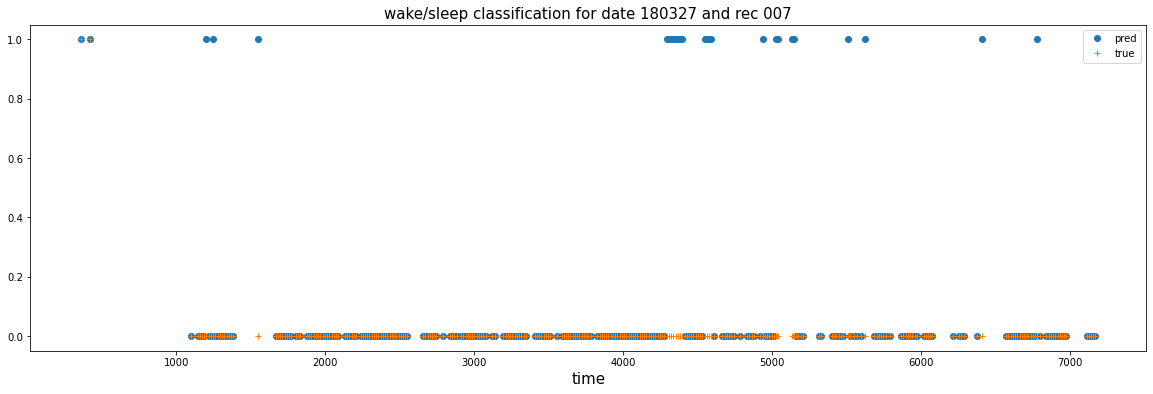

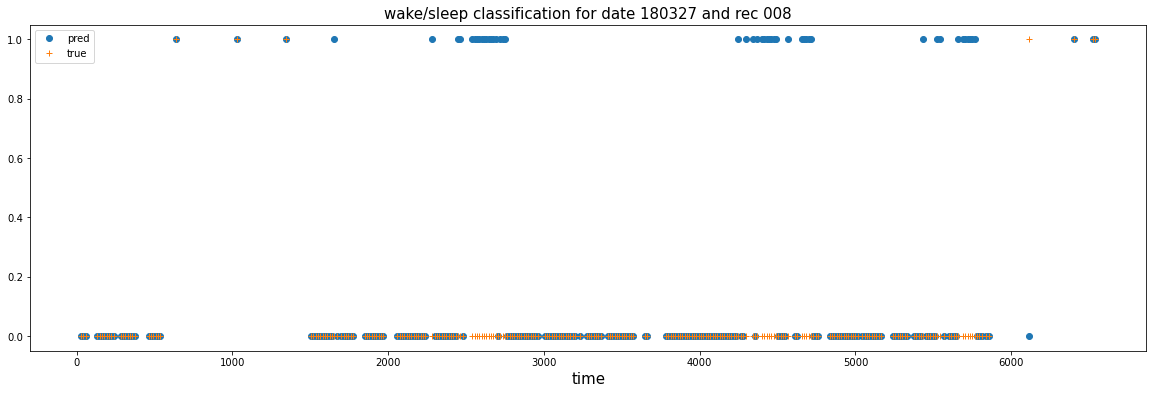

In [9]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.7157712578773499, train accuracy:0.8616223585548739, train percentage postive:0.5


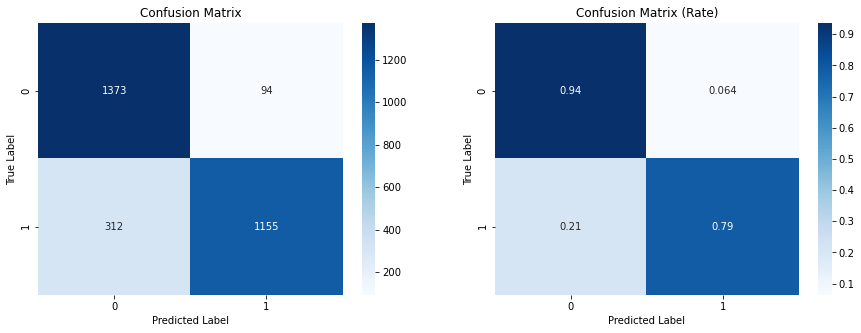

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [11]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 7.761380672454834
Val loss for epoch 0: 6.8215250968933105
3
Train loss for epoch 3: 2.8059780597686768
Val loss for epoch 3: 5.374790668487549
4
Train loss for epoch 4: 1.3504247665405273
Val loss for epoch 4: 3.843743324279785
5
Train loss for epoch 5: 0.7995060682296753
Val loss for epoch 5: 2.695960521697998
6
Train loss for epoch 6: 0.5632020831108093
Val loss for epoch 6: 1.5353120565414429
7
Train loss for epoch 7: 0.4091358184814453
Val loss for epoch 7: 1.4341132640838623
8
Train loss for epoch 8: 0.29872724413871765
Val loss for epoch 8: 1.2101207971572876
9
Train loss for epoch 9: 0.22258798778057098
Val loss for epoch 9: 0.7881664037704468
12
Train loss for epoch 12: 0.08051568269729614
Val loss for epoch 12: 0.6534841656684875


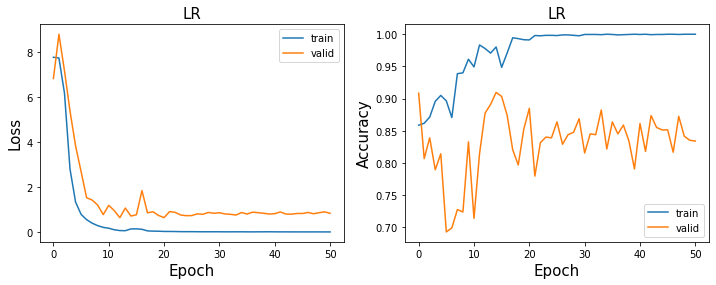

0
Train loss for epoch 0: 7.435629844665527
Val loss for epoch 0: 7.473567485809326
2
Train loss for epoch 2: 5.5175323486328125
Val loss for epoch 2: 6.632501125335693
3
Train loss for epoch 3: 2.049696683883667
Val loss for epoch 3: 3.90644907951355
4
Train loss for epoch 4: 1.3503925800323486
Val loss for epoch 4: 3.8991851806640625
5
Train loss for epoch 5: 0.9055095911026001
Val loss for epoch 5: 1.7359657287597656
6
Train loss for epoch 6: 0.5054233074188232
Val loss for epoch 6: 1.1361143589019775
7
Train loss for epoch 7: 0.3599534034729004
Val loss for epoch 7: 0.932191014289856
8
Train loss for epoch 8: 0.44889506697654724
Val loss for epoch 8: 0.8552433252334595
15
Train loss for epoch 15: 0.28876882791519165
Val loss for epoch 15: 0.8384466171264648
17
Train loss for epoch 17: 0.2848140001296997
Val loss for epoch 17: 0.6448280215263367


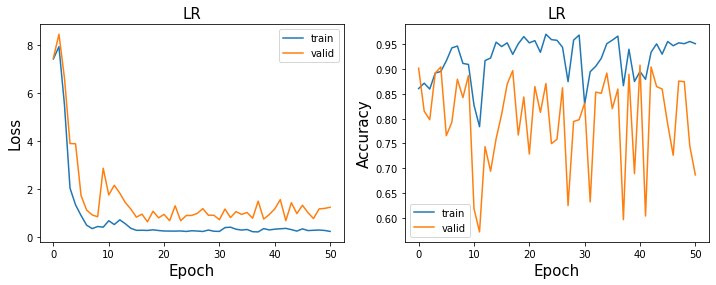

0
Train loss for epoch 0: 7.0988898277282715
Val loss for epoch 0: 7.247875213623047
2
Train loss for epoch 2: 3.0924153327941895
Val loss for epoch 2: 3.828744888305664
3
Train loss for epoch 3: 1.267350196838379
Val loss for epoch 3: 3.113612174987793
4
Train loss for epoch 4: 0.9752416610717773
Val loss for epoch 4: 1.2924696207046509
6
Train loss for epoch 6: 0.5254625082015991
Val loss for epoch 6: 0.7426568865776062
9
Train loss for epoch 9: 0.38953760266304016
Val loss for epoch 9: 0.6978018879890442
14
Train loss for epoch 14: 0.2799796164035797
Val loss for epoch 14: 0.657341480255127
21
Train loss for epoch 21: 0.35072794556617737
Val loss for epoch 21: 0.5490258932113647


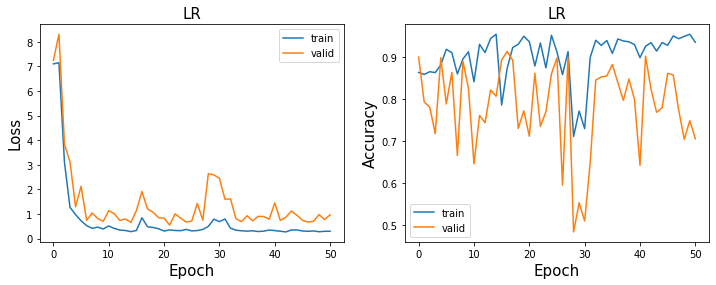

In [12]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.5490258932113647, val accuracy:0.8612143742255266, val percentage postive:0.0768277570605278


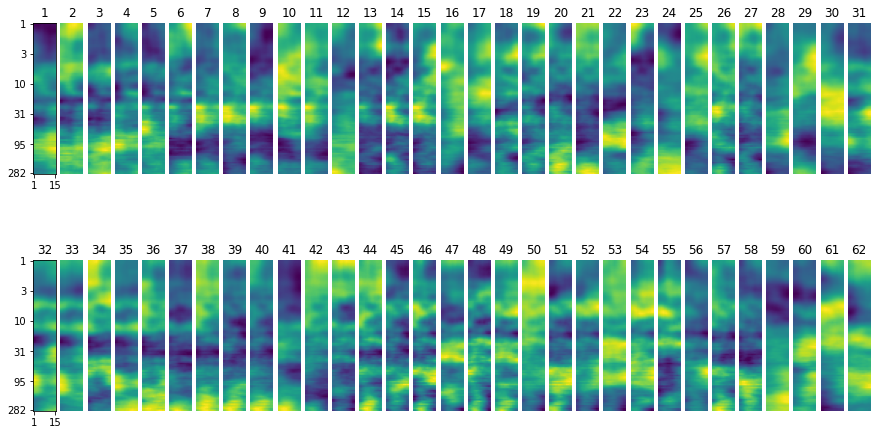

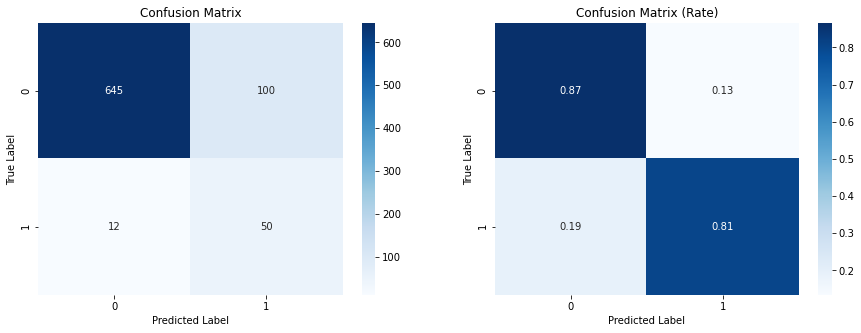

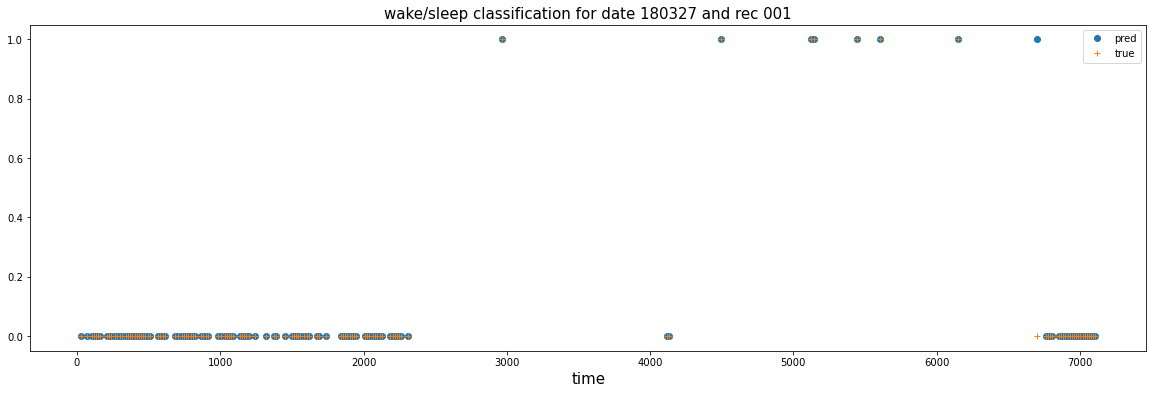

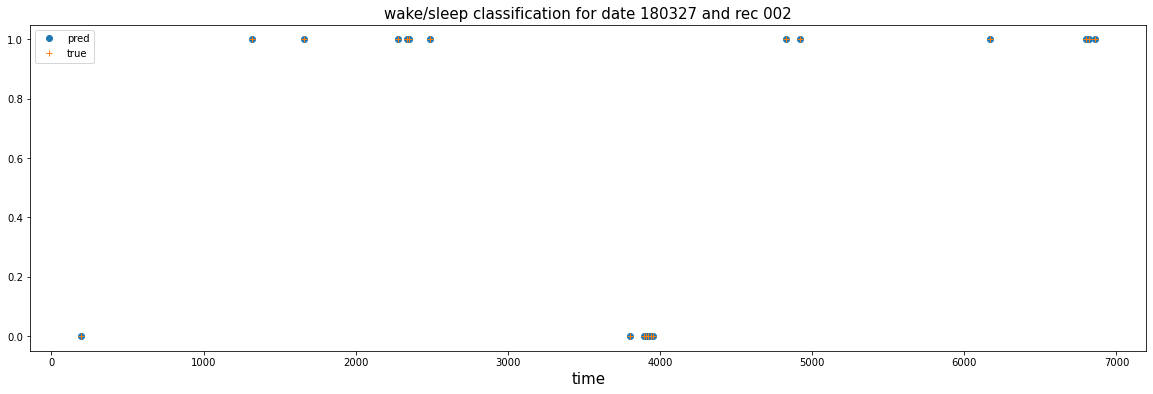

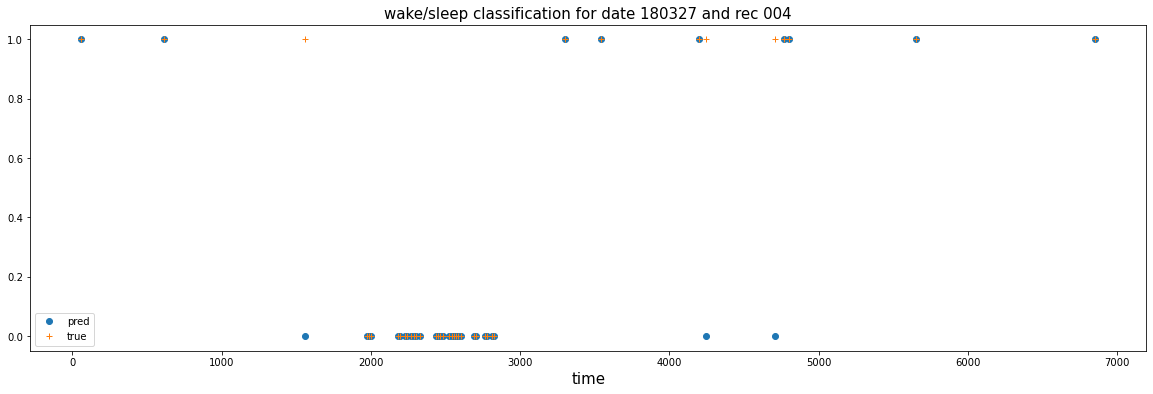

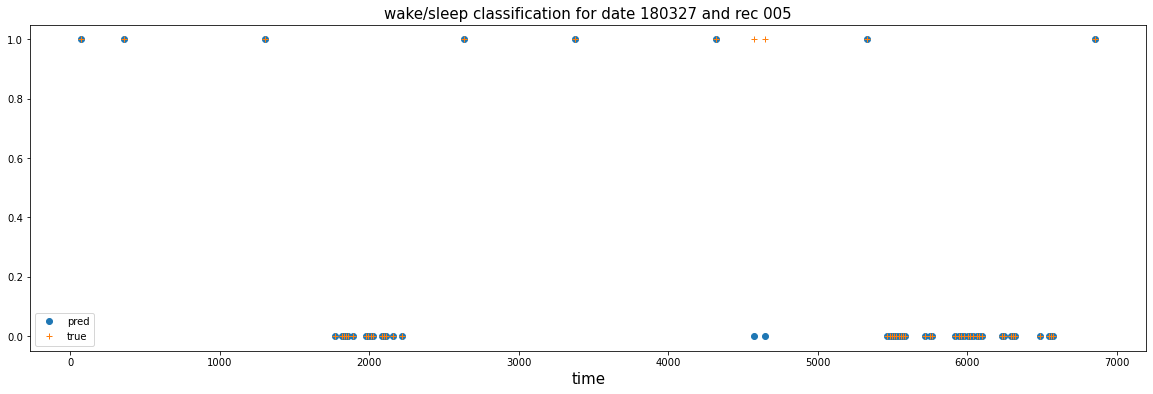

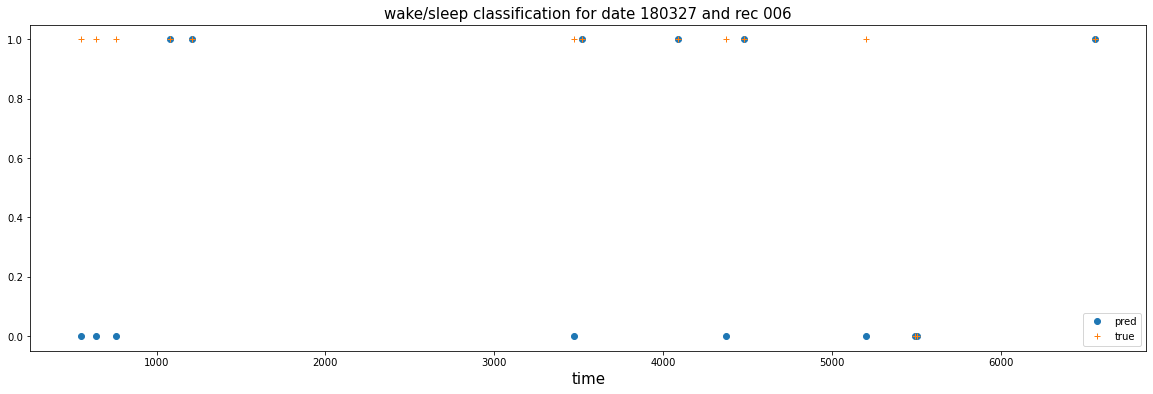

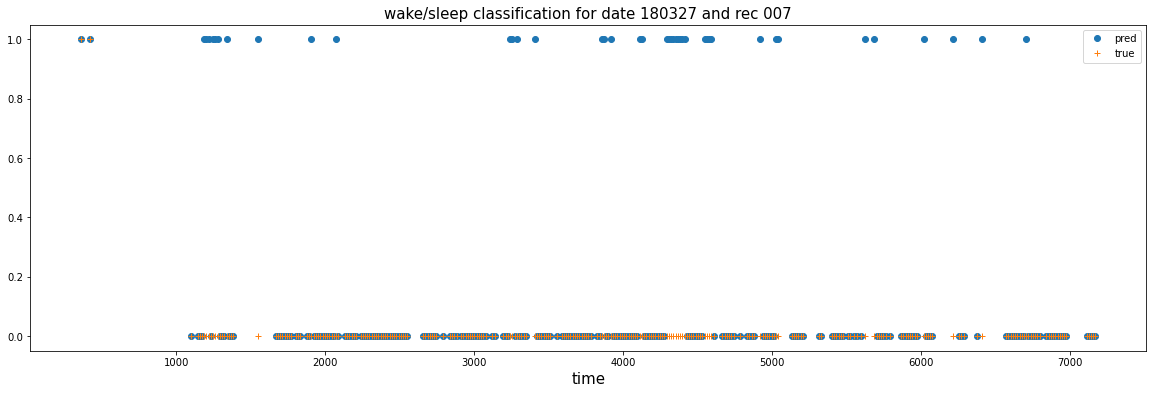

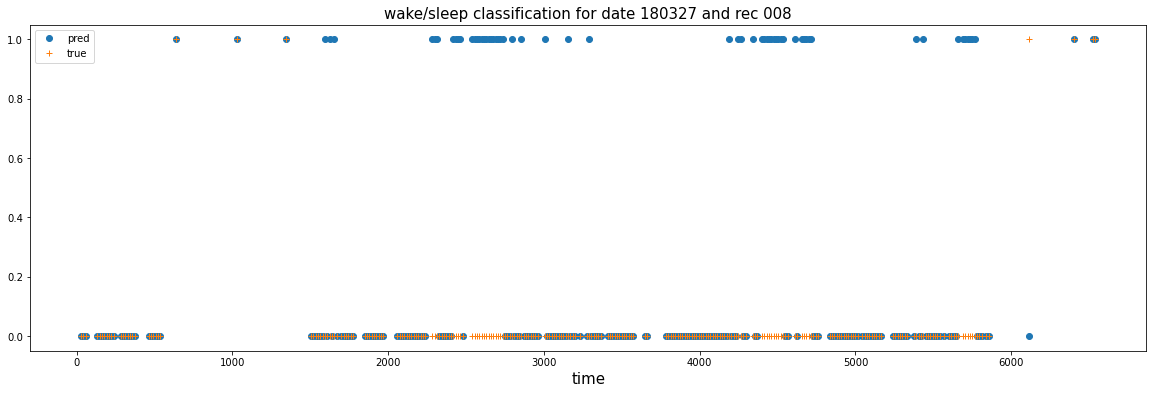

In [13]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.27148881554603577, train accuracy:0.9352419904567144, train percentage postive:0.5


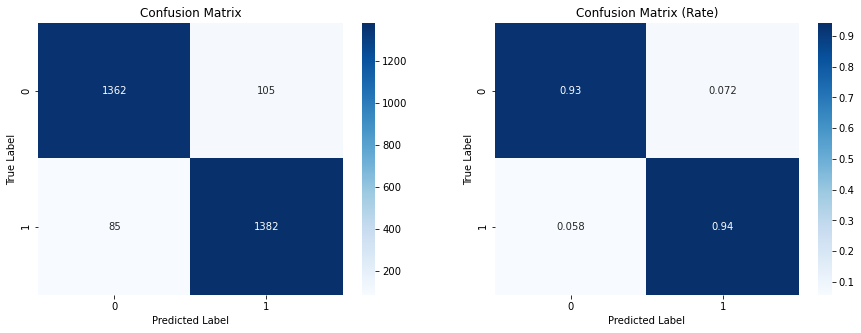

In [14]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)